# Diplomado en Ciencia de Datos - FES Acatlán, UNAM

# Práctica #1: Análisis y Modelado de Datos de Ecobici

**Contexto**  
En esta práctica, se utilizará un conjunto de datos histórico del sistema de bicicletas compartidas **Ecobici**, abarcando al menos los últimos 12 meses (Nuestro periodo estudiado es de Septiembre 2023 a Septiembre 2024). El objetivo principal es realizar un análisis exhaustivo y construir modelos predictivos basados en los datos disponibles. Este ejercicio busca reforzar los conocimientos en el manejo de datos con **pandas**, el diseño de modelos de regresión lineal y la toma de decisiones basadas en la interpretación de los resultados.

**Objetivos**
1. **Manipulación, limpieza y exploración de datos:**
   - Leer los archivos necesarios y realizar una inspección detallada de su contenido.
   - Identificar y resolver posibles inconsistencias antes de realizar la unión de los datos.
   - Justificar la metodología aplicada para garantizar la calidad e integridad del dataset combinado.

2. **Modelado de predicción de arribos:**
   - Construir un modelo de regresión lineal para pronosticar el número de bicicletas que arriban a las cicloestaciones con base en el historial de los últimos 7 días.
   - Realizar transformaciones necesarias en los datos, eliminar outliers y estructurar la tabla de análisis de datos (TAD) como:  
     `Ciclo_Estacion_Arribo, fecha_día_arribo, total_viajes_arribo`.

3. **Modelado de predicción de retiros:**
   - Adaptar el modelo visto en clase para predecir los retiros, estructurando la TAD como:  
     `Ciclo_Estacion_Retiro, fecha_día_retiro, total_viajes_retiro`.

4. **Análisis comparativo:**
   - Identificar la cicloestación con mayor variación entre los pronósticos de arribos y retiros.
   - Evaluar el impacto de estas variaciones en el sistema y proponer posibles soluciones basadas en las conclusiones obtenidas.

**Justificación**  
Este ejercicio no solo refuerza habilidades técnicas, sino también fomenta el análisis crítico y la colaboración en equipo para resolver problemas del mundo real. Además, proporciona una perspectiva práctica sobre cómo los datos pueden influir en la toma de decisiones para optimizar un sistema de transporte compartido.


## Librerías Utilizadas

In [95]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp
from scipy import stats

## Obtención de Datos

In [ ]:
# Ruta donde están los archivos
ruta = 'Ecobici_2023-2024/'
archivos = os.listdir(ruta)

# Fecha de inicio para filtrar
fecha_inicio = '2023-09'

# Filtrar archivos que sean iguales o posteriores a la fecha de inicio
listaArch = [
    archivo for archivo in archivos 
    if archivo.endswith('.csv') and archivo[:7] >= fecha_inicio
]

print(listaArch)

['2023-09.csv', '2023-10.csv', '2023-11.csv', '2023-12.csv', '2024-01.csv', '2024-02.csv', '2024-03.csv', '2024-04.csv', '2024-05.csv', '2024-06.csv', '2024-07.csv', '2024-08.csv', '2024-09.csv']


In [3]:
# Crear lista para almacenar chunks procesados
chunks_procesados = []

# Procesar cada archivo en chunks
for arch in listaArch:
    archivo_path = os.path.join(ruta, arch)
    try:
        # Leer el archivo por chunks
        for chunk in pd.read_csv(archivo_path, chunksize=100000):  # Leer en chunks de 100,000 filas
            # Renombrar columna si existe
            if 'Fecha Arribo' in chunk.columns:
                chunk.rename(columns={'Fecha Arribo': 'Fecha_Arribo'}, inplace=True)

            # Agregar el chunk procesado a la lista
            chunks_procesados.append(chunk)

    except Exception as e:
        print(f"Error al procesar el archivo {arch}: {e}")

# Concatenar todos los chunks en un DataFrame final
df_completo = pd.concat(chunks_procesados, ignore_index=True)

print("Tamaño total del DataFrame combinado:", df_completo.shape)

Tamaño total del DataFrame combinado: (21795535, 9)


Haga la lectura de los archivos que se necesitan. Ponga especial cuidado a la
información contenida en cada uno de los archivos y recuerde lo visto en
clase. ¿Los unirá sin preguntar primero? Justifique su respuesta.
Hint: Para unirlos todos puede ocupar el comando pandas.concat( ) sobre una
lista.

Con lo visto en clase, nos percatamos que había dos columnas llamadas diferente que hacían referencia a la misma información, estas columnas son 'Fecha Arribo' y 'Fecha_Arribo', más tarde el profesor nos apoyó a descargar un dataset más reciente o con datos más precisos que nos ayudó a solucionar este problema, pero igual decidimos dejar el código que resolvía este problema en caso de que se suguiera presentando.

Adicional, con la exploración de Dataset no vimos ningún otro reto similar

## Exploración del Dataset

In [4]:
#Renombrar a df.ecobici
df_ecobici = df_completo

# Mostrar un resumen de los datos
print(df_ecobici.head())

  Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro Fecha_Retiro  \
0              F          35.0  6696504                   056   31/08/2023   
1              M          26.0  4906764                   086   31/08/2023   
2              M          34.0  8041477                   121   31/08/2023   
3              M          29.0  8372245                   555   31/08/2023   
4              M          28.0  4092540                   041   31/08/2023   

  Hora_Retiro Ciclo_EstacionArribo Fecha_Arribo Hora_Arribo  
0    23:37:31                  328   01/09/2023    00:00:01  
1    23:54:05                  183   01/09/2023    00:00:12  
2    23:55:54                  056   01/09/2023    00:00:34  
3    23:51:20                  543   01/09/2023    00:00:38  
4    23:50:09                  543   01/09/2023    00:00:52  


In [5]:
#informqación del df
df_ecobici.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21795535 entries, 0 to 21795534
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Genero_Usuario         object 
 1   Edad_Usuario           float64
 2   Bici                   int64  
 3   Ciclo_Estacion_Retiro  object 
 4   Fecha_Retiro           object 
 5   Hora_Retiro            object 
 6   Ciclo_EstacionArribo   object 
 7   Fecha_Arribo           object 
 8   Hora_Arribo            object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5+ GB


In [6]:
df_ecobici.describe()

,Edad_Usuario,Bici
count,2.179535e+07,2.179554e+07
mean,3.375101e+01,5.461918e+06
std,9.686261e+00,2.029502e+06
min,1.600000e+01,2.000461e+06
25%,2.700000e+01,3.716222e+06
50%,3.200000e+01,5.449848e+06
75%,3.900000e+01,7.216393e+06
max,1.600000e+02,8.999708e+06


### Análisis de la Unión de Archivos y Exploración Inicial del Dataset

1. **¿Cómo proceder con la unión de los archivos?**
Antes de unir los archivos, es fundamental analizar cuidadosamente la información contenida en cada uno de ellos. No se debe proceder con la concatenación sin realizar una exploración previa para identificar posibles inconsistencias o problemas en las columnas y su contenido. Esto asegura que los datos combinados sean precisos y útiles para el análisis posterior.

**Justificación**
Durante la exploración inicial, nos encontramos con un problema en el que dos columnas, **'Fecha Arribo'** y **'Fecha_Arribo'**, representaban la misma información pero con nombres diferentes. Este tipo de discrepancias puede generar errores al unir los archivos. 

2. **Solución aplicada**
Para resolver este problema:
  - **Exploración del Dataset:** Identificamos las columnas duplicadas mediante una inspección manual y automatizada.
  - **Limpieza:** Creamos un código que unifica ambas columnas bajo un único nombre, asegurándonos de que la información quede estandarizada.

Posteriormente, el profesor proporcionó un dataset más reciente y con datos más precisos, lo que ayudó a eliminar el problema en su origen. Sin embargo, decidimos mantener el código que resolvía la discrepancia en caso de que volviera a presentarse con futuros datos.

3. **Otros retos encontrados**
Tras una exploración superficial del dataset, no se identificaron problemas adicionales de similar naturaleza. Esto permitió proceder con la unión de los archivos sobre una lista de DataFrames.

**Nota**:
Se recomienda continuar aplicando estas prácticas de exploración y limpieza en futuros análisis para garantizar la integridad de los datos.


## Manipulación, Limpieza y Exploración

In [7]:
# Quitar todos los espacios en blanco en todo el DataFrame
df_ecobici = df_ecobici.replace(r'\s+', '', regex=True)

# Verificar resultado
print(df_ecobici.head())

  Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro Fecha_Retiro  \
0              F          35.0  6696504                   056   31/08/2023   
1              M          26.0  4906764                   086   31/08/2023   
2              M          34.0  8041477                   121   31/08/2023   
3              M          29.0  8372245                   555   31/08/2023   
4              M          28.0  4092540                   041   31/08/2023   

  Hora_Retiro Ciclo_EstacionArribo Fecha_Arribo Hora_Arribo  
0    23:37:31                  328   01/09/2023    00:00:01  
1    23:54:05                  183   01/09/2023    00:00:12  
2    23:55:54                  056   01/09/2023    00:00:34  
3    23:51:20                  543   01/09/2023    00:00:38  
4    23:50:09                  543   01/09/2023    00:00:52  


In [8]:
# Unificar formato de Fecha_Retiro (primero concatenar con Hora_Retiro)
df_ecobici['Fecha_Retiro'] = pd.to_datetime(
    df_ecobici['Fecha_Retiro'] + ' ' + df_ecobici['Hora_Retiro'], 
    format='%d/%m/%Y %H:%M:%S', errors='coerce'
)

# Unificar formato de Fecha_Arribo (concatenar con Hora_Arribo)
df_ecobici['Fecha_Arribo'] = pd.to_datetime(
    df_ecobici['Fecha_Arribo'].astype(str) + ' ' + df_ecobici['Hora_Arribo'], 
    format='%d/%m/%Y %H:%M:%S', errors='coerce'
)

# Confirmar los cambios y verificar las conversiones
print(df_ecobici.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21795535 entries, 0 to 21795534
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Genero_Usuario         object        
 1   Edad_Usuario           float64       
 2   Bici                   int64         
 3   Ciclo_Estacion_Retiro  object        
 4   Fecha_Retiro           datetime64[ns]
 5   Hora_Retiro            object        
 6   Ciclo_EstacionArribo   object        
 7   Fecha_Arribo           datetime64[ns]
 8   Hora_Arribo            object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 1.5+ GB
None


In [9]:
print(df_ecobici.head())

  Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro  \
0              F          35.0  6696504                   056   
1              M          26.0  4906764                   086   
2              M          34.0  8041477                   121   
3              M          29.0  8372245                   555   
4              M          28.0  4092540                   041   

         Fecha_Retiro Hora_Retiro Ciclo_EstacionArribo        Fecha_Arribo  \
0 2023-08-31 23:37:31    23:37:31                  328 2023-09-01 00:00:01   
1 2023-08-31 23:54:05    23:54:05                  183 2023-09-01 00:00:12   
2 2023-08-31 23:55:54    23:55:54                  056 2023-09-01 00:00:34   
3 2023-08-31 23:51:20    23:51:20                  543 2023-09-01 00:00:38   
4 2023-08-31 23:50:09    23:50:09                  543 2023-09-01 00:00:52   

  Hora_Arribo  
0    00:00:01  
1    00:00:12  
2    00:00:34  
3    00:00:38  
4    00:00:52  


In [10]:
# Eliminar las columnas 'Hora_Retiro' y 'Hora_Arribo'
#df_ecobici = df_ecobici.drop(['Hora_Retiro', 'Hora_Arribo'], axis=1)

# Confirmar los cambios
#print(df_ecobici.info())

In [11]:
# Verificar si hay valores nulos en el DataFrame
nulos = df_ecobici.isna().sum()

# Mostrar las columnas con valores nulos
print(nulos)

Genero_Usuario            71
Edad_Usuario             183
Bici                       0
Ciclo_Estacion_Retiro      0
Fecha_Retiro               0
Hora_Retiro                0
Ciclo_EstacionArribo       0
Fecha_Arribo               0
Hora_Arribo                0
dtype: int64


In [12]:
# Contar los valores en 'Genero_Usuario', incluyendo los nulos
genero_counts = df_ecobici['Genero_Usuario'].value_counts(dropna=False)
# Mostrar los valores
print(genero_counts)

# Contar los valores en 'Edad_Usuario', incluyendo los nulos
edad_counts = df_ecobici['Edad_Usuario'].value_counts(dropna=False)
# Ordenar por edad de menor a mayor
edad_counts_sorted = edad_counts.sort_index()
# Mostrar los valores ordenados
print(edad_counts_sorted)

Genero_Usuario
M      15101209
F       6260457
O        433662
?           136
NaN          71
Name: count, dtype: int64
Edad_Usuario
16.0       5142
17.0      11977
18.0      93063
19.0     236143
20.0     322611
          ...  
124.0         1
137.0         5
152.0         2
160.0         7
NaN         183
Name: count, Length: 95, dtype: int64


In [13]:
# Crear columnas fecha_día_retiro y fecha_día_arribo a partir de las fechas respectivas
df_ecobici = df_ecobici.assign(
    fecha_día_retiro=pd.to_datetime(df_ecobici['Fecha_Retiro'].dt.date),
    fecha_día_arribo=pd.to_datetime(df_ecobici['Fecha_Arribo'].dt.date)
)

df_ecobici.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
0,F,35.0,6696504,056,2023-08-31 23:37:31,23:37:31,328,2023-09-01 00:00:01,00:00:01,2023-08-31,2023-09-01
1,M,26.0,4906764,086,2023-08-31 23:54:05,23:54:05,183,2023-09-01 00:00:12,00:00:12,2023-08-31,2023-09-01
2,M,34.0,8041477,121,2023-08-31 23:55:54,23:55:54,056,2023-09-01 00:00:34,00:00:34,2023-08-31,2023-09-01
3,M,29.0,8372245,555,2023-08-31 23:51:20,23:51:20,543,2023-09-01 00:00:38,00:00:38,2023-08-31,2023-09-01
4,M,28.0,4092540,041,2023-08-31 23:50:09,23:50:09,543,2023-09-01 00:00:52,00:00:52,2023-08-31,2023-09-01


In [14]:
# Agrupar datos por 'Ciclo_Estacion_Retiro' y 'fecha_día_arribo'
# Contar el total de viajes (registros en la columna 'Bici') para cada combinación
viajes_retiro = (
    df_ecobici.groupby(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'])['Bici']
    .count()
    .reset_index(name='total_viajes_retiro')
)

viajes_arribo = (
    df_ecobici.groupby(['Ciclo_Estacion_Retiro', 'fecha_día_arribo'])['Bici']
    .count()
    .reset_index(name='total_viajes_arribo')
)

# Mostrar resultados
print("Viajes por Retiro:")
print(viajes_retiro.head())
print("\nViajes por Arribo:")
print(viajes_arribo.head())

Viajes por Retiro:
  Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                   001       2023-09-01                  254
1                   001       2023-09-02                  124
2                   001       2023-09-03                  162
3                   001       2023-09-04                  246
4                   001       2023-09-05                  266

Viajes por Arribo:
  Ciclo_Estacion_Retiro fecha_día_arribo  total_viajes_arribo
0                   001       2023-09-01                  254
1                   001       2023-09-02                  122
2                   001       2023-09-03                  164
3                   001       2023-09-04                  244
4                   001       2023-09-05                  267


In [15]:
viajes_retiro.info()
viajes_arribo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250068 entries, 0 to 250067
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Ciclo_Estacion_Retiro  250068 non-null  object        
 1   fecha_día_retiro       250068 non-null  datetime64[ns]
 2   total_viajes_retiro    250068 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250013 entries, 0 to 250012
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Ciclo_Estacion_Retiro  250013 non-null  object        
 1   fecha_día_arribo       250013 non-null  datetime64[ns]
 2   total_viajes_arribo    250013 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.7+ MB


In [16]:
# Ordenar por 'Ciclo_Estacion_Retiro' y 'fecha_día_retiro'
viajes_retiro_ordenados = viajes_retiro.sort_values(
    by=['Ciclo_Estacion_Retiro', 'fecha_día_retiro']
)

# Ordenar por 'Ciclo_Estacion_Retiro' y 'fecha_día_arribo'
viajes_arribo_ordenados = viajes_arribo.sort_values(
    by=['Ciclo_Estacion_Retiro', 'fecha_día_arribo']
)

# Mostrar resultados ordenados
print("Viajes por Retiro Ordenados:")
print(viajes_retiro_ordenados.head())
print("\nViajes por Arribo Ordenados:")
print(viajes_arribo_ordenados.head())

Viajes por Retiro Ordenados:
  Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                   001       2023-09-01                  254
1                   001       2023-09-02                  124
2                   001       2023-09-03                  162
3                   001       2023-09-04                  246
4                   001       2023-09-05                  266

Viajes por Arribo Ordenados:
  Ciclo_Estacion_Retiro fecha_día_arribo  total_viajes_arribo
0                   001       2023-09-01                  254
1                   001       2023-09-02                  122
2                   001       2023-09-03                  164
3                   001       2023-09-04                  244
4                   001       2023-09-05                  267


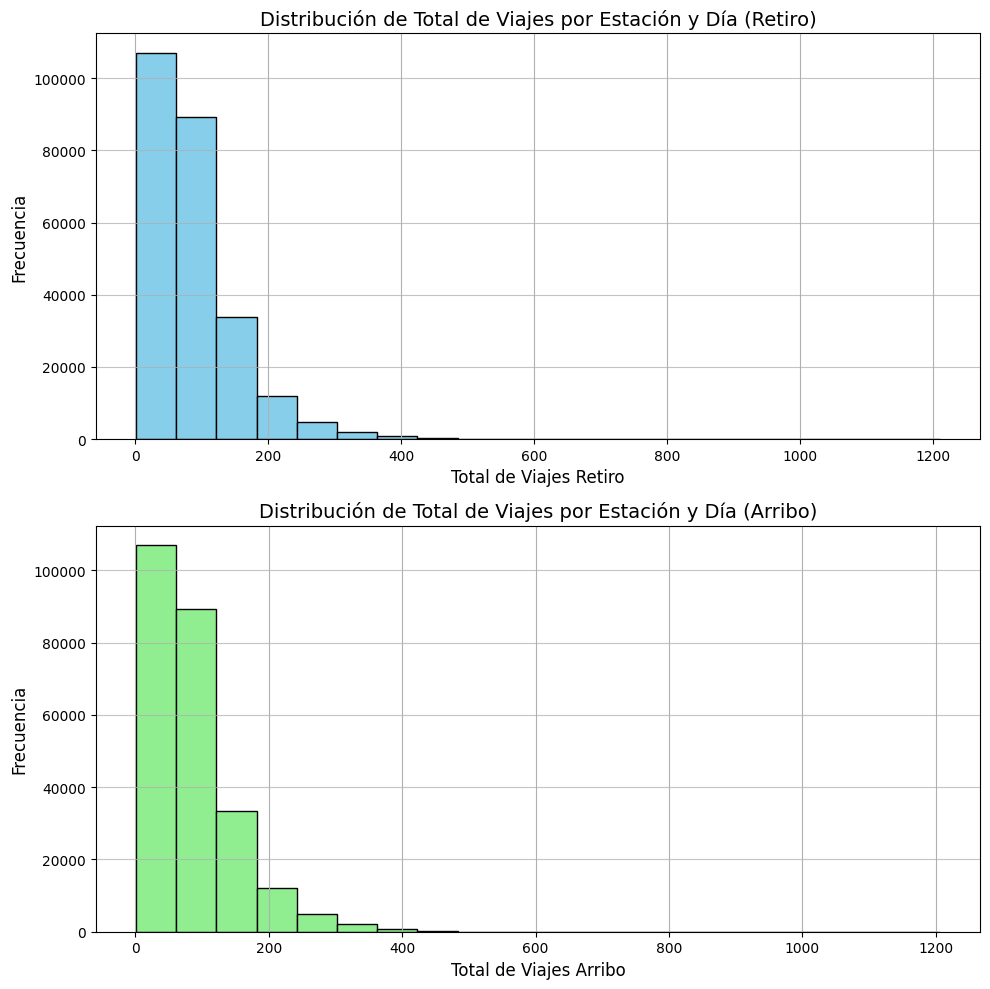

In [17]:
# Crear subgráficas (2 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Histograma para 'fecha_día_retiro'
viajes_retiro_ordenados['total_viajes_retiro'].hist(bins=20, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribución de Total de Viajes por Estación y Día (Retiro)', fontsize=14)  # Título
axes[0].set_xlabel('Total de Viajes Retiro', fontsize=12)  # Etiqueta del eje X
axes[0].set_ylabel('Frecuencia', fontsize=12)  # Etiqueta del eje Y
axes[0].grid(axis='y', alpha=0.75)  # Cuadrícula

# Histograma para 'fecha_día_arribo'
viajes_arribo_ordenados['total_viajes_arribo'].hist(bins=20, color='lightgreen', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribución de Total de Viajes por Estación y Día (Arribo)', fontsize=14)  # Título
axes[1].set_xlabel('Total de Viajes Arribo', fontsize=12)  # Etiqueta del eje X
axes[1].set_ylabel('Frecuencia', fontsize=12)  # Etiqueta del eje Y
axes[1].grid(axis='y', alpha=0.75)  # Cuadrícula

# Ajustar la visualización para que no se superpongan
plt.tight_layout()
plt.show()

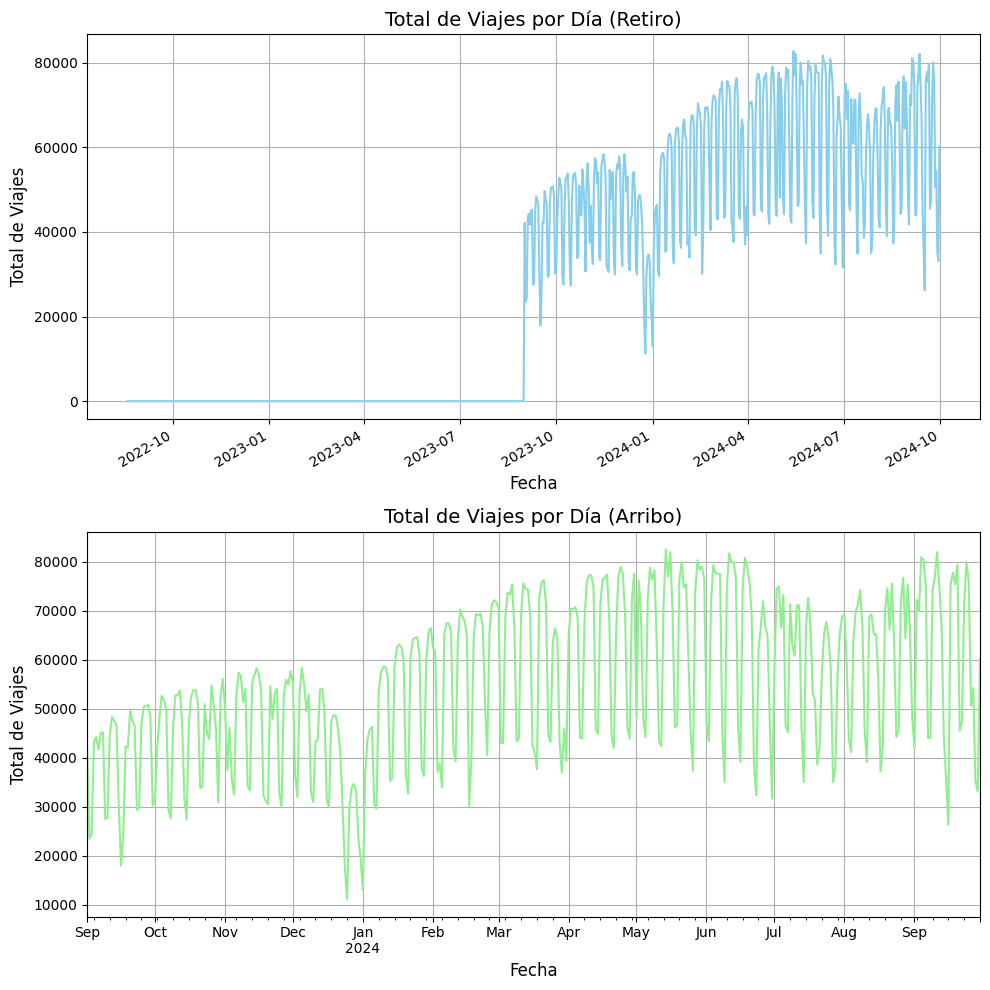

In [18]:
# Agrupar por 'fecha_día_retiro' y sumar los viajes
viajes_retiro_diario = viajes_retiro_ordenados.groupby('fecha_día_retiro')['total_viajes_retiro'].sum().reset_index()

# Agrupar por 'fecha_día_arribo' y sumar los viajes
viajes_arribo_diario = viajes_arribo_ordenados.groupby('fecha_día_arribo')['total_viajes_arribo'].sum().reset_index()

# Crear subgráficas (2 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Gráfico para viajes de retiro
viajes_retiro_diario.set_index('fecha_día_retiro')['total_viajes_retiro'].plot(ax=axes[0], color='skyblue')
axes[0].set_title('Total de Viajes por Día (Retiro)', fontsize=14)
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Total de Viajes', fontsize=12)
axes[0].grid(True)

# Gráfico para viajes de arribo
viajes_arribo_diario.set_index('fecha_día_arribo')['total_viajes_arribo'].plot(ax=axes[1], color='lightgreen')
axes[1].set_title('Total de Viajes por Día (Arribo)', fontsize=14)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Total de Viajes', fontsize=12)
axes[1].grid(True)

# Ajustar la visualización para que no se superpongan
plt.tight_layout()
plt.show()

### Análisis de Fechas Desfasadas en el Dataset

Se ha observado que en los registros de **viajes por día en Retiro**, existen valores que no corresponden al periodo de análisis establecido (09/2023 - 09/2024). Estos registros pertenecen a meses anteriores, lo cual indica que hay **fechas desfasadas** que deben ser exploradas y gestionadas adecuadamente.

**Próximos Pasos:**
- Realizar una exploración detallada del dataset para identificar los registros con fechas fuera del rango indicado.
- Analizar el impacto de estas discrepancias en el modelo y decidir la mejor estrategia para manejarlas.

In [19]:
df_ecobici_ordenado = df_ecobici.sort_values(by=['fecha_día_retiro', 'fecha_día_arribo'], ascending=[True, True])
df_ecobici_ordenado


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
19473545,M,55.0,5404058,378,2022-08-19 14:44:45,14:44:45,347,2024-08-24 14:40:22,14:40:22,2022-08-19,2024-08-24
3690150,O,29.0,5380423,056,2022-09-30 12:24:36,12:24:36,1000,2023-11-24 15:13:34,15:13:34,2022-09-30,2023-11-24
14887161,O,48.0,7164288,079,2022-10-07 15:29:21,15:29:21,1000,2024-06-10 04:34:52,04:34:52,2022-10-07,2024-06-10
12746163,M,65.0,4097465,247,2022-11-05 13:12:09,13:12:09,1000,2024-05-08 13:09:45,13:09:45,2022-11-05,2024-05-08
81111,M,30.0,6032056,668,2023-02-03 23:42:43,23:42:43,312,2023-09-03 14:56:25,14:56:25,2023-02-03,2023-09-03
...,...,...,...,...,...,...,...,...,...,...,...
21795530,M,31.0,8088551,425,2024-09-30 23:49:18,23:49:18,371,2024-09-30 23:59:19,23:59:19,2024-09-30,2024-09-30
21795531,F,31.0,7701659,107-108,2024-09-30 23:48:06,23:48:06,006,2024-09-30 23:59:23,23:59:23,2024-09-30,2024-09-30
21795532,M,23.0,2022929,004,2024-09-30 23:44:19,23:44:19,505,2024-09-30 23:59:37,23:59:37,2024-09-30,2024-09-30
21795533,F,62.0,2449668,004,2024-09-30 23:48:29,23:48:29,111,2024-09-30 23:59:44,23:59:44,2024-09-30,2024-09-30


In [20]:
# Filtrar los registros con fecha anterior al 01/09/2023 y ordenarlos por fecha de retiro
ecobici_filtrado_fechas_antriores = (
    df_ecobici_ordenado[df_ecobici_ordenado['fecha_día_retiro'] < '2023-09-01']
    .sort_values(by='fecha_día_retiro', ascending=True)
)

# Obtener el número total de registros después del filtrado
total_registros = ecobici_filtrado_fechas_antriores.shape[0]

# Mostrar los primeros registros y el total de registros
print(ecobici_filtrado_fechas_antriores.head())
print(f'Número de registros: {total_registros}')

         Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro  \
19473545              M          55.0  5404058                   378   
3690150               O          29.0  5380423                   056   
14887161              O          48.0  7164288                   079   
12746163              M          65.0  4097465                   247   
81111                 M          30.0  6032056                   668   

                Fecha_Retiro Hora_Retiro Ciclo_EstacionArribo  \
19473545 2022-08-19 14:44:45    14:44:45                  347   
3690150  2022-09-30 12:24:36    12:24:36                 1000   
14887161 2022-10-07 15:29:21    15:29:21                 1000   
12746163 2022-11-05 13:12:09    13:12:09                 1000   
81111    2023-02-03 23:42:43    23:42:43                  312   

                Fecha_Arribo Hora_Arribo fecha_día_retiro fecha_día_arribo  
19473545 2024-08-24 14:40:22    14:40:22       2022-08-19       2024-08-24  
3690150  2023-11-24 15

### Análisis de Registros Desfasados

Se ha identificado un total de **103 registros** con fechas desfasadas, los cuales no corresponden al periodo observado. Estos registros se encuentran en el dataset debido a que la **Fecha de Arribo** pertenece al periodo correcto, pero la **Fecha de Retiro** está fuera de rango.

**Decisión:**
- Se ha decidido **no tomar en cuenta** estos 103 registros, ya que su impacto en el análisis y el modelo es mínimo y no afecta de manera significativa los resultados obtenidos.


In [21]:
#Filtro entre ese rango de fechas para el DataFrame completo
df_ecobici = df_ecobici[(df_ecobici['fecha_día_retiro']>='2023-09-01')&(df_ecobici['fecha_día_retiro']<='2024-09-30')]
df_ecobici

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
25,M,32.0,5477435,125,2023-09-01 00:03:06,00:03:06,116,2023-09-01 00:06:43,00:06:43,2023-09-01,2023-09-01
26,M,27.0,4057717,125,2023-09-01 00:03:09,00:03:09,116,2023-09-01 00:06:44,00:06:44,2023-09-01,2023-09-01
30,M,40.0,7678402,064,2023-09-01 00:03:53,00:03:53,050,2023-09-01 00:07:37,00:07:37,2023-09-01,2023-09-01
32,M,32.0,8150203,182,2023-09-01 00:03:59,00:03:59,080,2023-09-01 00:07:54,00:07:54,2023-09-01,2023-09-01
35,M,34.0,6041420,107-108,2023-09-01 00:01:10,00:01:10,271-272,2023-09-01 00:08:31,00:08:31,2023-09-01,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...
21795530,M,31.0,8088551,425,2024-09-30 23:49:18,23:49:18,371,2024-09-30 23:59:19,23:59:19,2024-09-30,2024-09-30
21795531,F,31.0,7701659,107-108,2024-09-30 23:48:06,23:48:06,006,2024-09-30 23:59:23,23:59:23,2024-09-30,2024-09-30
21795532,M,23.0,2022929,004,2024-09-30 23:44:19,23:44:19,505,2024-09-30 23:59:37,23:59:37,2024-09-30,2024-09-30
21795533,F,62.0,2449668,004,2024-09-30 23:48:29,23:48:29,111,2024-09-30 23:59:44,23:59:44,2024-09-30,2024-09-30


In [22]:
# Agrupar datos por 'Ciclo_Estacion_Retiro' y 'fecha_día_arribo'
# Contar el total de viajes (registros en la columna 'Bici') para cada combinación
viajes_retiro = (
    df_ecobici.groupby(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'])['Bici']
    .count()
    .reset_index(name='total_viajes_retiro')
)

viajes_arribo = (
    df_ecobici.groupby(['Ciclo_Estacion_Retiro', 'fecha_día_arribo'])['Bici']
    .count()
    .reset_index(name='total_viajes_arribo')
)

# Mostrar resultados
print("Viajes por Retiro:")
print(viajes_retiro.head())
print("\nViajes por Arribo:")
print(viajes_arribo.head())

Viajes por Retiro:
  Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                   001       2023-09-01                  254
1                   001       2023-09-02                  124
2                   001       2023-09-03                  162
3                   001       2023-09-04                  246
4                   001       2023-09-05                  266

Viajes por Arribo:
  Ciclo_Estacion_Retiro fecha_día_arribo  total_viajes_arribo
0                   001       2023-09-01                  254
1                   001       2023-09-02                  122
2                   001       2023-09-03                  164
3                   001       2023-09-04                  244
4                   001       2023-09-05                  267


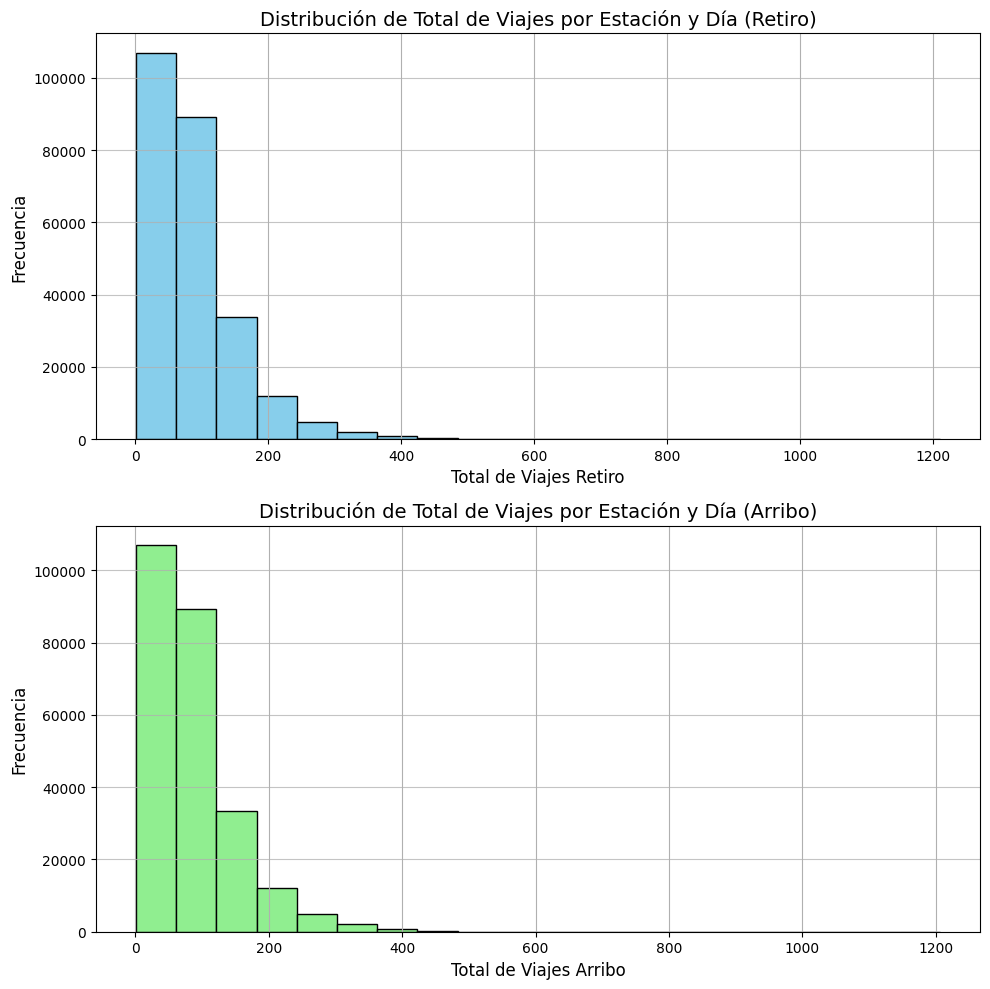

In [23]:
# Crear subgráficas (2 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Histograma para 'fecha_día_retiro'
viajes_retiro['total_viajes_retiro'].hist(bins=20, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribución de Total de Viajes por Estación y Día (Retiro)', fontsize=14)  # Título
axes[0].set_xlabel('Total de Viajes Retiro', fontsize=12)  # Etiqueta del eje X
axes[0].set_ylabel('Frecuencia', fontsize=12)  # Etiqueta del eje Y
axes[0].grid(axis='y', alpha=0.75)  # Cuadrícula

# Histograma para 'fecha_día_arribo'
viajes_arribo['total_viajes_arribo'].hist(bins=20, color='lightgreen', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribución de Total de Viajes por Estación y Día (Arribo)', fontsize=14)  # Título
axes[1].set_xlabel('Total de Viajes Arribo', fontsize=12)  # Etiqueta del eje X
axes[1].set_ylabel('Frecuencia', fontsize=12)  # Etiqueta del eje Y
axes[1].grid(axis='y', alpha=0.75)  # Cuadrícula

# Ajustar la visualización para que no se superpongan
plt.tight_layout()
plt.show()

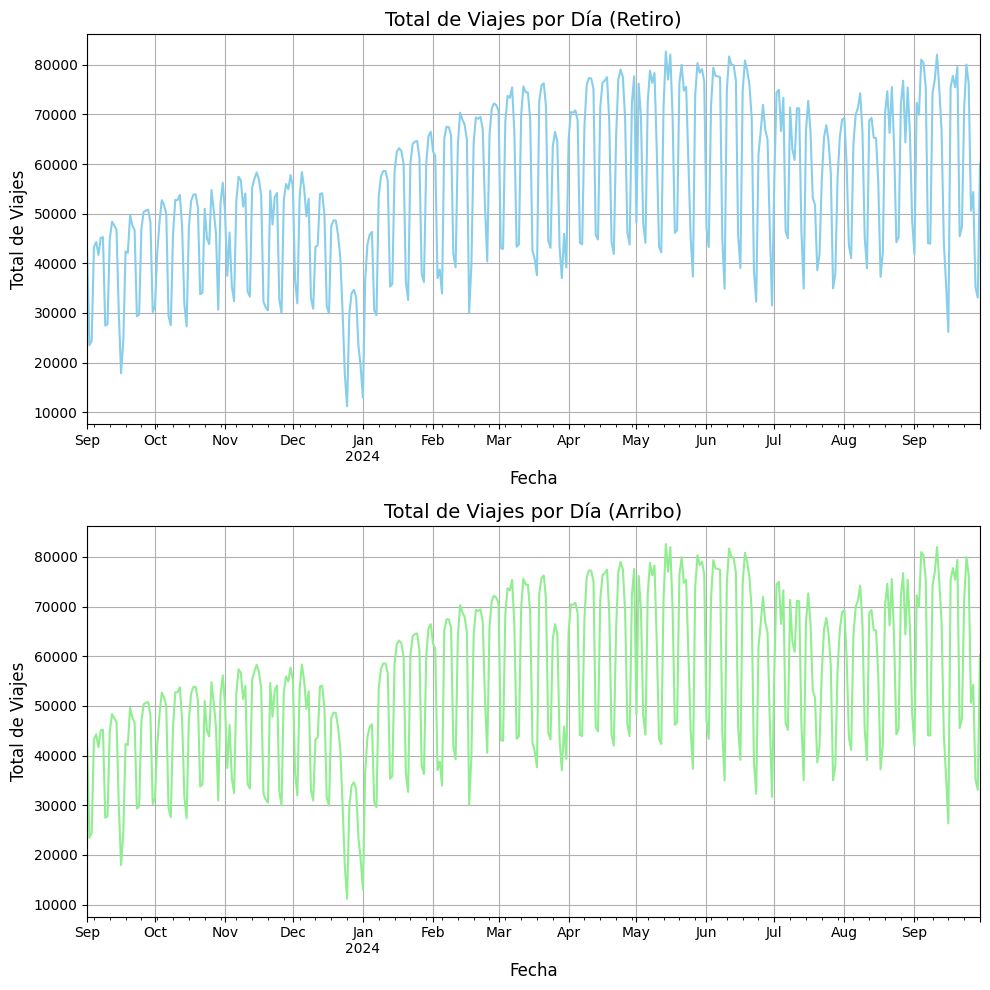

In [24]:
# Agrupar por 'fecha_día_retiro' y sumar los viajes
viajes_retiro_diario = viajes_retiro.groupby('fecha_día_retiro')['total_viajes_retiro'].sum().reset_index()

# Agrupar por 'fecha_día_arribo' y sumar los viajes
viajes_arribo_diario = viajes_arribo.groupby('fecha_día_arribo')['total_viajes_arribo'].sum().reset_index()

# Crear subgráficas (2 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Gráfico para viajes de retiro
viajes_retiro_diario.set_index('fecha_día_retiro')['total_viajes_retiro'].plot(ax=axes[0], color='skyblue')
axes[0].set_title('Total de Viajes por Día (Retiro)', fontsize=14)
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Total de Viajes', fontsize=12)
axes[0].grid(True)

# Gráfico para viajes de arribo
viajes_arribo_diario.set_index('fecha_día_arribo')['total_viajes_arribo'].plot(ax=axes[1], color='lightgreen')
axes[1].set_title('Total de Viajes por Día (Arribo)', fontsize=14)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Total de Viajes', fontsize=12)
axes[1].grid(True)

# Ajustar la visualización para que no se superpongan
plt.tight_layout()
plt.show()

In [25]:
#Validar si hay fechas en fecha_día_arribo que no correspondan al mismo mes
# Filtrar las filas donde los meses sean diferentes
df_ecobici_diferente_mesArribo = df_ecobici[df_ecobici['fecha_día_retiro'].dt.month != df_ecobici['fecha_día_arribo'].dt.month]

# Mostrar las discrepancias encontradas
print(df_ecobici_diferente_mesArribo)

         Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro  \
1189636               M          29.0  5210661                   134   
1189637               M          26.0  8316747                   045   
1189638               M          30.0  3749272                   384   
1189639               F          40.0  2961233                   014   
1189640               F          34.0  2661924                   155   
...                 ...           ...      ...                   ...   
20204284              M          28.0  5619994                   261   
20336904              F          34.0  7743321                   573   
20434577              M          25.0  5700265                   374   
20484341              M          28.0  2006351                   006   
21377405              F          36.0  3829173                   138   

                Fecha_Retiro Hora_Retiro Ciclo_EstacionArribo  \
1189636  2023-09-30 23:55:54    23:55:54                  147   
11896

In [26]:
df_ecobici_diferente_mesArribo

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
1189636,M,29.0,5210661,134,2023-09-30 23:55:54,23:55:54,147,2023-10-01 00:00:16,00:00:16,2023-09-30,2023-10-01
1189637,M,26.0,8316747,045,2023-09-30 23:46:57,23:46:57,147,2023-10-01 00:00:32,00:00:32,2023-09-30,2023-10-01
1189638,M,30.0,3749272,384,2023-09-30 23:50:50,23:50:50,337,2023-10-01 00:00:34,00:00:34,2023-09-30,2023-10-01
1189639,F,40.0,2961233,014,2023-09-30 23:50:24,23:50:24,018,2023-10-01 00:00:36,00:00:36,2023-09-30,2023-10-01
1189640,F,34.0,2661924,155,2023-09-30 23:55:48,23:55:48,139,2023-10-01 00:00:39,00:00:39,2023-09-30,2023-10-01
...,...,...,...,...,...,...,...,...,...,...,...
20204284,M,28.0,5619994,261,2024-08-22 20:52:02,20:52:02,086,2024-09-04 21:42:05,21:42:05,2024-08-22,2024-09-04
20336904,F,34.0,7743321,573,2024-08-30 15:33:49,15:33:49,573,2024-09-06 16:44:03,16:44:03,2024-08-30,2024-09-06
20434577,M,25.0,5700265,374,2024-08-26 18:45:21,18:45:21,1000,2024-09-08 15:29:29,15:29:29,2024-08-26,2024-09-08
20484341,M,28.0,2006351,006,2024-08-08 16:53:11,16:53:11,1000,2024-09-09 14:25:52,14:25:52,2024-08-08,2024-09-09


In [27]:
# Filtrar las discrepancias donde fecha_día_arribo no sea de septiembre 2023
df_septiembre_discrepancias = df_ecobici_diferente_mesArribo[
    (df_ecobici_diferente_mesArribo['fecha_día_retiro'].dt.month == 10) & 
    (df_ecobici_diferente_mesArribo['fecha_día_retiro'].dt.year == 2023) & 
    (df_ecobici_diferente_mesArribo['fecha_día_arribo'].dt.month != 10)
]

# Ordenar de menor a mayor por 'fecha_día_retiro'
df_septiembre_discrepancias = df_septiembre_discrepancias.sort_values(by='fecha_día_retiro', ascending=True)

# Mostrar las discrepancias ordenadas
df_septiembre_discrepancias

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
3525441,M,28.0,5491121,190,2023-10-03 08:51:26,08:51:26,049,2023-11-21 11:43:45,11:43:45,2023-10-03,2023-11-21
6206845,M,29.0,4911160,187,2023-10-09 18:40:06,18:40:06,091,2024-01-21 22:21:20,22:21:20,2023-10-09,2024-01-21
17349755,M,61.0,2288926,007,2023-10-13 12:06:14,12:06:14,560,2024-07-19 08:25:44,08:25:44,2023-10-13,2024-07-19
14652428,M,35.0,4912986,271-272,2023-10-21 17:44:45,17:44:45,1000,2024-06-06 04:40:41,04:40:41,2023-10-21,2024-06-06
9475838,M,45.0,2525855,020,2023-10-25 19:24:11,19:24:11,1000,2024-03-16 15:34:40,15:34:40,2023-10-25,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...
2591472,M,38.0,5017173,117,2023-10-31 23:49:25,23:49:25,091,2023-11-01 00:05:59,00:05:59,2023-10-31,2023-11-01
2591473,M,21.0,6261663,163,2023-10-31 23:48:24,23:48:24,317,2023-11-01 00:06:03,00:06:03,2023-10-31,2023-11-01
2591474,M,19.0,7481898,091,2023-10-31 23:51:39,23:51:39,091,2023-11-01 00:06:12,00:06:12,2023-10-31,2023-11-01
2591467,M,57.0,5836309,069,2023-10-31 23:51:51,23:51:51,312,2023-11-01 00:05:16,00:05:16,2023-10-31,2023-11-01


In [28]:
# Crear un DataFrame para almacenar los resultados
resultados = []

# Obtener los años y meses únicos del dataset
meses_anios_unicos = df_ecobici['fecha_día_retiro'].dt.to_period('M').unique()

# Iterar por cada mes y año único en fecha_día_retiro
for periodo in meses_anios_unicos:
    # Filtrar las filas del mes actual en fecha_día_retiro
    df_mes_actual = df_ecobici[df_ecobici['fecha_día_retiro'].dt.to_period('M') == periodo]
    
    # Total de registros del mes actual
    total_mes = len(df_mes_actual)
    
    # Filtrar las discrepancias donde el mes/año actual no coincida con fecha_día_arribo
    df_discrepancias = df_ecobici_diferente_mesArribo[
        (df_ecobici_diferente_mesArribo['fecha_día_retiro'].dt.to_period('M') == periodo) & 
        (df_ecobici_diferente_mesArribo['fecha_día_arribo'].dt.to_period('M') != periodo)
    ]
    
    # Ordenar las discrepancias de menor a mayor por 'fecha_día_retiro'
    df_discrepancias = df_discrepancias.sort_values(by='fecha_día_retiro', ascending=True)
    
    # Cantidad de discrepancias del mes actual
    cantidad_desfasadas = len(df_discrepancias)
    
    # Calcular el porcentaje de desfaces
    porcentaje_desfasadas = (cantidad_desfasadas / total_mes) * 100 if total_mes > 0 else 0
    
    # Agregar los resultados a la lista
    resultados.append((periodo, cantidad_desfasadas, total_mes, porcentaje_desfasadas))

# Crear un DataFrame con el resumen de resultados
df_resumen_discrepancias = pd.DataFrame(resultados, columns=['Mes_Año', 'Cantidad_Desfasadas', 'Total_Mes', 'Porcentaje_Desfasadas'])

# Calcular los totales
total_desfasadas = df_resumen_discrepancias['Cantidad_Desfasadas'].sum()
total_registros = df_resumen_discrepancias['Total_Mes'].sum()
porcentaje_acumulado = (total_desfasadas / total_registros) * 100 if total_registros > 0 else 0

# Agregar un resumen total al final del DataFrame
df_resumen_discrepancias.loc['Total'] = ['Total', total_desfasadas, total_registros, porcentaje_acumulado]

# Mostrar el resumen
print(df_resumen_discrepancias)

       Mes_Año  Cantidad_Desfasadas  Total_Mes  Porcentaje_Desfasadas
0      2023-09                  158    1189708               0.013281
1      2023-10                  153    1401775               0.010915
2      2023-11                  198    1410704               0.014036
3      2023-12                   84    1228214               0.006839
4      2024-01                  155    1558172               0.009948
5      2024-02                  212    1699470               0.012474
6      2024-03                  111    1829657               0.006067
7      2024-04                  227    1961744               0.011571
8      2024-05                  353    2053686               0.017189
9      2024-06                   72    1893235               0.003803
10     2024-07                  193    1825775               0.010571
11     2024-08                  241    1891358               0.012742
12     2024-09                    0    1851934               0.000000
Total    Total      

### Análisis de Fechas de Arribo y Retiro en Archivos Mensuales

1. **¿Mis archivos mensuales contienen datos de otro mes ajenos a la etiqueta de descarga?**
Sí, se identificaron fechas de **Arribo** que pertenecen a otros periodos de meses. Esto ocurre porque la bicicleta pudo haberse retirado de una cicloestación en una fecha (e.g., 30 de septiembre) y arribado en otra fecha correspondiente al siguiente mes (e.g., 1 de octubre).

2. **De ser así, ¿cómo convendría abordar el problema?**
Se realizó un análisis del problema para entender el comportamiento de los datos. Se observó que este fenómeno ocurre mayoritariamente en casos donde los retiros y arribos se encuentran al final e inicio de meses consecutivos. Este comportamiento es natural y esperado en un sistema de registro continuo como el de bicicletas compartidas.

3. **¿Los borro de inicio? ¿Comparo entre lo contenido en algunos archivos y decido? ¿Los agrego de golpe?**
No se eliminaron las fechas de arribo desfasadas desde el principio. En su lugar, se realizó un análisis detallado. Como resultado, se concluyó que las fechas de arribo desfasadas representan el **0.0098%** del conjunto de datos total. Este porcentaje es insignificante y no afecta el desempeño de futuros modelos analíticos o de machine learning, por lo que se decidió no incluirlas en el análisis general.


In [29]:
df_ecobici

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,fecha_día_retiro,fecha_día_arribo
25,M,32.0,5477435,125,2023-09-01 00:03:06,00:03:06,116,2023-09-01 00:06:43,00:06:43,2023-09-01,2023-09-01
26,M,27.0,4057717,125,2023-09-01 00:03:09,00:03:09,116,2023-09-01 00:06:44,00:06:44,2023-09-01,2023-09-01
30,M,40.0,7678402,064,2023-09-01 00:03:53,00:03:53,050,2023-09-01 00:07:37,00:07:37,2023-09-01,2023-09-01
32,M,32.0,8150203,182,2023-09-01 00:03:59,00:03:59,080,2023-09-01 00:07:54,00:07:54,2023-09-01,2023-09-01
35,M,34.0,6041420,107-108,2023-09-01 00:01:10,00:01:10,271-272,2023-09-01 00:08:31,00:08:31,2023-09-01,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...
21795530,M,31.0,8088551,425,2024-09-30 23:49:18,23:49:18,371,2024-09-30 23:59:19,23:59:19,2024-09-30,2024-09-30
21795531,F,31.0,7701659,107-108,2024-09-30 23:48:06,23:48:06,006,2024-09-30 23:59:23,23:59:23,2024-09-30,2024-09-30
21795532,M,23.0,2022929,004,2024-09-30 23:44:19,23:44:19,505,2024-09-30 23:59:37,23:59:37,2024-09-30,2024-09-30
21795533,F,62.0,2449668,004,2024-09-30 23:48:29,23:48:29,111,2024-09-30 23:59:44,23:59:44,2024-09-30,2024-09-30


In [30]:
# Eliminar las filas donde los meses de 'fecha_día_arribo' y 'fecha_día_retiro' sean diferentes en el df completo
df_ecobici = df_ecobici[df_ecobici['fecha_día_retiro'].dt.month == df_ecobici['fecha_día_arribo'].dt.month]

# Verifica el DataFrame resultante
print(df_ecobici)

         Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro  \
25                    M          32.0  5477435                   125   
26                    M          27.0  4057717                   125   
30                    M          40.0  7678402                   064   
32                    M          32.0  8150203                   182   
35                    M          34.0  6041420               107-108   
...                 ...           ...      ...                   ...   
21795530              M          31.0  8088551                   425   
21795531              F          31.0  7701659               107-108   
21795532              M          23.0  2022929                   004   
21795533              F          62.0  2449668                   004   
21795534              M          32.0  7130065                   453   

                Fecha_Retiro Hora_Retiro Ciclo_EstacionArribo  \
25       2023-09-01 00:03:06    00:03:06                  116   
26   

In [31]:
# Renombrar la columna
df_ecobici.rename(columns={'Ciclo_EstacionArribo': 'Ciclo_Estacion_Arribo'}, inplace=True)

# Verifica el DataFrame con el nuevo nombre de columna
print(df_ecobici.head())

   Genero_Usuario  Edad_Usuario     Bici Ciclo_Estacion_Retiro  \
25              M          32.0  5477435                   125   
26              M          27.0  4057717                   125   
30              M          40.0  7678402                   064   
32              M          32.0  8150203                   182   
35              M          34.0  6041420               107-108   

          Fecha_Retiro Hora_Retiro Ciclo_Estacion_Arribo        Fecha_Arribo  \
25 2023-09-01 00:03:06    00:03:06                   116 2023-09-01 00:06:43   
26 2023-09-01 00:03:09    00:03:09                   116 2023-09-01 00:06:44   
30 2023-09-01 00:03:53    00:03:53                   050 2023-09-01 00:07:37   
32 2023-09-01 00:03:59    00:03:59                   080 2023-09-01 00:07:54   
35 2023-09-01 00:01:10    00:01:10               271-272 2023-09-01 00:08:31   

   Hora_Arribo fecha_día_retiro fecha_día_arribo  
25    00:06:43       2023-09-01       2023-09-01  
26    00:06:44      

C:\Users\ANMEJIA\AppData\Local\Temp\ipykernel_110312\1181825566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ecobici.rename(columns={'Ciclo_EstacionArribo': 'Ciclo_Estacion_Arribo'}, inplace=True)


In [62]:
# Agrupar datos por 'Ciclo_Estacion_Retiro' y 'fecha_día_arribo'
# Contar el total de viajes (registros en la columna 'Bici') para cada combinación
viajes_retiro = (
    df_ecobici.groupby(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'])['Bici']
    .count()
    .reset_index(name='total_viajes_retiro')
)

viajes_arribo = (
    df_ecobici.groupby(['Ciclo_Estacion_Arribo', 'fecha_día_arribo'])['Bici']
    .count()
    .reset_index(name='total_viajes_arribo')
)

# Mostrar resultados
print("Viajes por Retiro:")
print(viajes_retiro)
print("\nViajes por Arribo:")
print(viajes_arribo)

Viajes por Retiro:
       Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                        001       2023-09-01                  254
1                        001       2023-09-02                  124
2                        001       2023-09-03                  162
3                        001       2023-09-04                  245
4                        001       2023-09-05                  266
...                      ...              ...                  ...
249982                CE-622       2023-11-30                   10
249983                CE-642       2023-11-28                    4
249984                CE-642       2023-11-29                   13
249985                CE-642       2023-11-30                    9
249986          Kiosco150177       2023-12-29                    1

[249987 rows x 3 columns]

Viajes por Arribo:
       Ciclo_Estacion_Arribo fecha_día_arribo  total_viajes_arribo
0                        001       2023-09-01                  

In [63]:
# Crear el rango de fechas
fecha_inicio = '2023-09-01'
fecha_fin = '2024-09-30'
fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

# -----------------------
# Procesar datos de retiro
# -----------------------
# Ordenar por fecha ascendente
viajes_retiro.sort_values(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'], inplace=True)

# Crear índice con Ciclo_Estacion_Retiro y fecha_día_retiro
viajes_retiro.set_index(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'], inplace=True)

# Valores únicos de las Ciclo_Estacion_Retiro
ids_retiro = viajes_retiro.index.get_level_values('Ciclo_Estacion_Retiro').unique()

# Construir índice completo
index_retiro = pd.MultiIndex.from_product([ids_retiro, fechas], names=['Ciclo_Estacion_Retiro', 'fecha_día_retiro'])

# Reindexar para incluir todas las fechas
viajes_retiro = viajes_retiro.reindex(index_retiro)

# Regresar el índice a columnas
viajes_retiro.reset_index(inplace=True)

nulos_retiro = viajes_retiro['total_viajes_retiro'].isna().sum()
porcen_nulos_retiro = nulos_retiro / len(viajes_retiro)

# -----------------------
# Procesar datos de arribo
# -----------------------
# Ordenar por fecha ascendente
viajes_arribo.sort_values(['Ciclo_Estacion_Arribo', 'fecha_día_arribo'], inplace=True)

# Crear índice con Ciclo_Estacion_Arribo y fecha_día_arribo
viajes_arribo.set_index(['Ciclo_Estacion_Arribo', 'fecha_día_arribo'], inplace=True)

# Valores únicos de las Ciclo_Estacion_Arribo
ids_arribo = viajes_arribo.index.get_level_values('Ciclo_Estacion_Arribo').unique()

# Construir índice completo
index_arribo = pd.MultiIndex.from_product([ids_arribo, fechas], names=['Ciclo_Estacion_Arribo', 'fecha_día_arribo'])

# Reindexar para incluir todas las fechas
viajes_arribo = viajes_arribo.reindex(index_arribo)

# Regresar el índice a columnas
viajes_arribo.reset_index(inplace=True)

# Contar nulos
nulos_arribo = viajes_arribo['total_viajes_arribo'].isna().sum()
porcen_nulos_arribo = nulos_arribo / len(viajes_arribo)

# -----------------------
# Mostrar resultados
# -----------------------
print("Viajes por Retiro:")
print(viajes_retiro.head())
print(f"\nCantidad de nulos en retiro: {nulos_retiro}")
print(f"Proporción de nulos en retiro: {porcen_nulos_retiro:.2%}")

print("\nViajes por Arribo:")
print(viajes_arribo.head())
print(f"\nCantidad de nulos en arribo: {nulos_arribo}")
print(f"Proporción de nulos en arribo: {porcen_nulos_arribo:.2%}")

Viajes por Retiro:
  Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                   001       2023-09-01                254.0
1                   001       2023-09-02                124.0
2                   001       2023-09-03                162.0
3                   001       2023-09-04                245.0
4                   001       2023-09-05                266.0

Cantidad de nulos en retiro: 20481
Proporción de nulos en retiro: 7.57%

Viajes por Arribo:
  Ciclo_Estacion_Arribo fecha_día_arribo  total_viajes_arribo
0                   001       2023-09-01                256.0
1                   001       2023-09-02                133.0
2                   001       2023-09-03                155.0
3                   001       2023-09-04                266.0
4                   001       2023-09-05                306.0

Cantidad de nulos en arribo: 20667
Proporción de nulos en arribo: 7.63%


In [64]:
#Los nulos representan el 7.63%

#Hacer un groupby para saber la cantidad de nulos que tiene cada estación
viajes_retiro_CE_nulos = viajes_retiro.groupby('Ciclo_Estacion_Retiro')['total_viajes_retiro'].apply(lambda x: x.isnull().sum()).reset_index(name='nulos')

#Filtrar las ciclo estaciones que tienen nulos y ordernarlos de menor a mayor 
viajes_retiro_CE_nulos = viajes_retiro_CE_nulos[viajes_retiro_CE_nulos['nulos']!=0]
viajes_retiro_CE_nulos.sort_values('nulos', inplace=True)

#Hacer un groupby para saber la cantidad de nulos que tiene cada estación
viajes_arribo_CE_nulos = viajes_arribo.groupby('Ciclo_Estacion_Arribo')['total_viajes_arribo'].apply(lambda x: x.isnull().sum()).reset_index(name='nulos')

#Filtrar las ciclo estaciones que tienen nulos y ordernarlos de menor a mayor 
viajes_arribo_CE_nulos = viajes_arribo_CE_nulos[viajes_arribo_CE_nulos['nulos']!=0]
viajes_arribo_CE_nulos.sort_values('nulos', inplace=True)

#Estaciones que tienen nulos
display(viajes_retiro_CE_nulos,
viajes_arribo_CE_nulos)

,Ciclo_Estacion_Retiro,nulos
21,022,1
17,018,1
31,032,1
40,041,1
114,115,1
...,...,...
411,4422222,391
681,CE-642,393
680,CE-622,394
101,1002,395


,Ciclo_Estacion_Arribo,nulos
15,016,1
17,018,1
19,020,1
40,041,1
31,032,1
...,...,...
681,CE-642,393
680,CE-622,394
101,1002,395
682,Kiosco150177,395


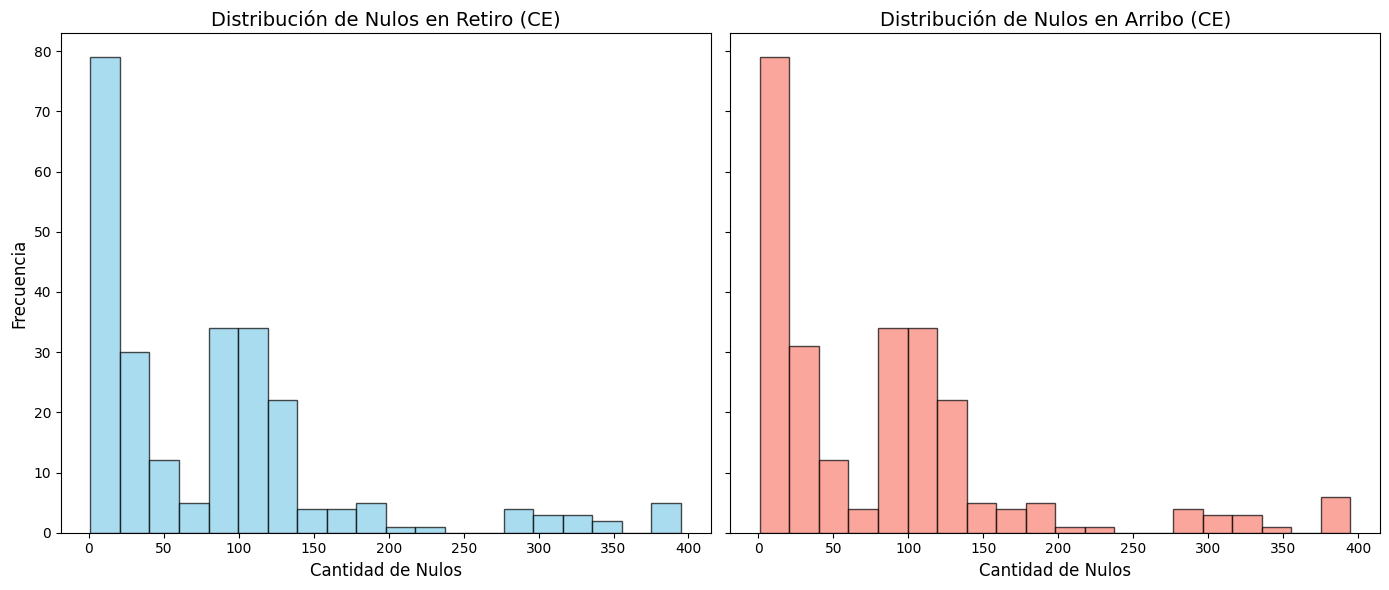

In [65]:
#Distribución de nulos
# Crear una figura con dos subgráficos para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histograma para viajes de retiro
axes[0].hist(viajes_retiro_CE_nulos['nulos'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Nulos en Retiro (CE)', fontsize=14)
axes[0].set_xlabel('Cantidad de Nulos', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)

# Histograma para viajes de arribo
axes[1].hist(viajes_arribo_CE_nulos['nulos'], bins=20, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Nulos en Arribo (CE)', fontsize=14)
axes[1].set_xlabel('Cantidad de Nulos', fontsize=12)

# Ajustar espacio entre subgráficos
plt.tight_layout()

# Mostrar los histogramas
plt.show()

In [ ]:
#Filtro para ver las estaciones con más valores nulos
viajes_retiro_CE_nulos_max = viajes_retiro_CE_nulos[viajes_retiro_CE_nulos['nulos']>300]
print(viajes_retiro_CE_nulos_max['nulos'].sum())


#Filtro para ver las estaciones con más valores nulos
viajes_arribo_CE_nulos_max = viajes_arribo_CE_nulos[viajes_arribo_CE_nulos['nulos']>300]
print(viajes_arribo_CE_nulos_max['nulos'].sum())

display(viajes_retiro_CE_nulos_max, viajes_arribo_CE_nulos_max)

4236
5759


,Ciclo_Estacion_Retiro,nulos
497,529,307
498,530,307
678,710,320
679,711,321
479,511,327
100,1000,336
492,524,350
411,4422222,391
681,CE-642,393
680,CE-622,394


,Ciclo_Estacion_Arribo,nulos
645,677,291
650,682,291
644,676,291
649,681,291
643,675,299
497,529,307
498,530,307
678,710,320
679,711,322
479,511,327


Cantidad total de nulos en retiro con más de 300 nulos:  14935
Cantidad total de nulos en arribo con más de 300 nulos:  15139


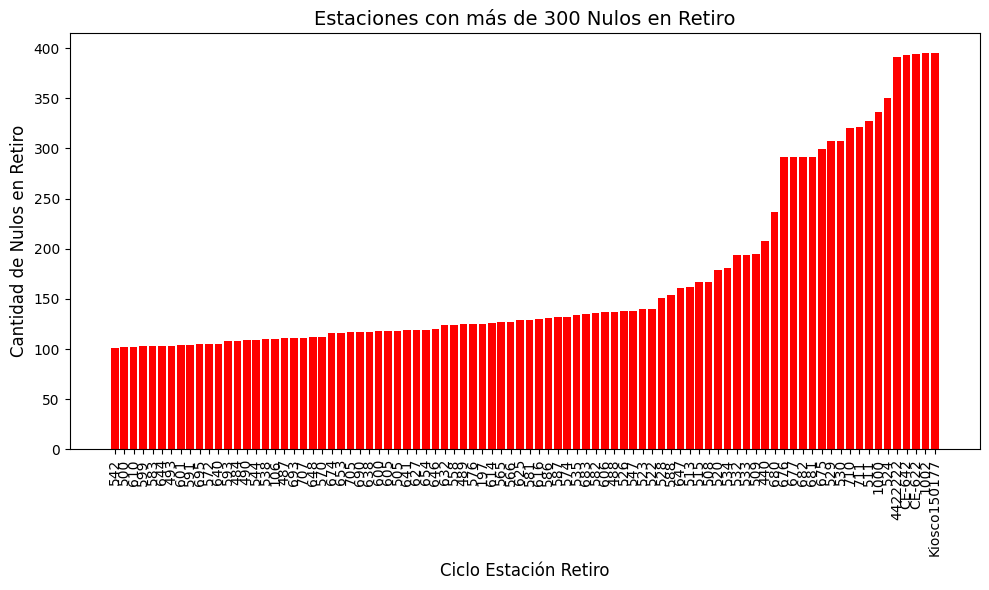

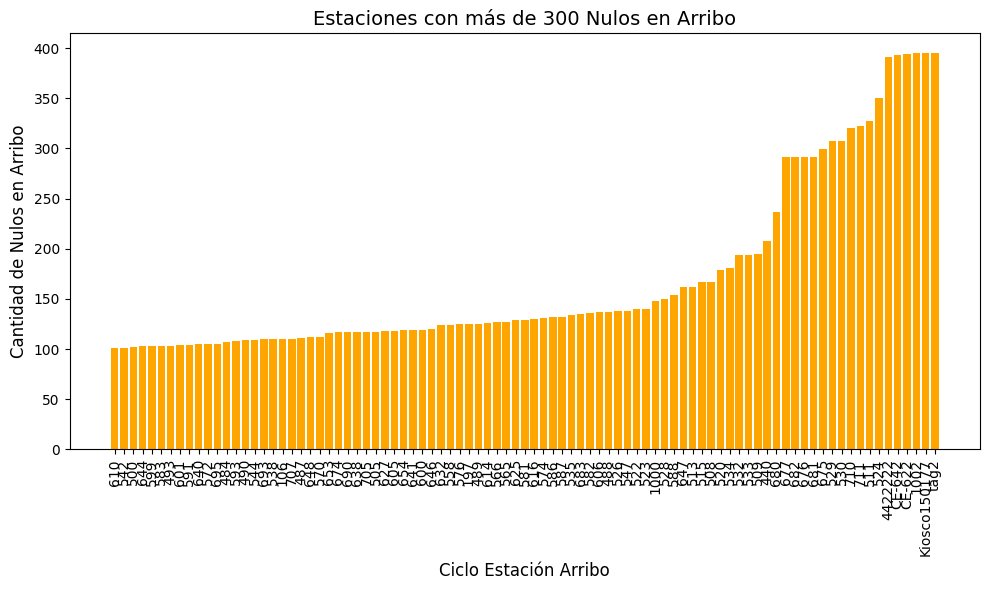

In [79]:
# Filtro para las estaciones con más de 300 nulos en retiro
viajes_retiro_CE_nulos_max = viajes_retiro_CE_nulos[viajes_retiro_CE_nulos['nulos'] > 100]
print("Cantidad total de nulos en retiro con más de 300 nulos: ", viajes_retiro_CE_nulos_max['nulos'].sum())

# Filtro para las estaciones con más de 300 nulos en arribo
viajes_arribo_CE_nulos_max = viajes_arribo_CE_nulos[viajes_arribo_CE_nulos['nulos'] > 100]
print("Cantidad total de nulos en arribo con más de 300 nulos: ", viajes_arribo_CE_nulos_max['nulos'].sum())

# Graficar para retiro
plt.figure(figsize=(10, 6))
plt.bar(viajes_retiro_CE_nulos_max['Ciclo_Estacion_Retiro'], viajes_retiro_CE_nulos_max['nulos'], color='r')
plt.title('Estaciones con más de 300 Nulos en Retiro', fontsize=14)
plt.xlabel('Ciclo Estación Retiro', fontsize=12)
plt.ylabel('Cantidad de Nulos en Retiro', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Graficar para arribo
plt.figure(figsize=(10, 6))
plt.bar(viajes_arribo_CE_nulos_max['Ciclo_Estacion_Arribo'], viajes_arribo_CE_nulos_max['nulos'], color='orange')
plt.title('Estaciones con más de 300 Nulos en Arribo', fontsize=14)
plt.xlabel('Ciclo Estación Arribo', fontsize=12)
plt.ylabel('Cantidad de Nulos en Arribo', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Como podemos apreciar, se muestra las ciclo estacionews con mayor numero de nulos, significa que son las cicloestaciones que no tienen uso

In [72]:
# Filtrar las estaciones con más registros no nulos (valores no nulos menores a 300)
viajes_retiro_CE_no_nulos_max = viajes_retiro_CE_nulos[viajes_retiro_CE_nulos['nulos'] < 10]
print("Cantidad de viajes no nulos en retiro: ", viajes_retiro_CE_no_nulos_max['nulos'].isna().sum())

# Filtrar las estaciones con más registros no nulos (valores no nulos menores a 300)
viajes_arribo_CE_no_nulos_max = viajes_arribo_CE_nulos[viajes_arribo_CE_nulos['nulos'] < 10]
print("Cantidad de viajes no nulos en arribo: ", viajes_arribo_CE_no_nulos_max['nulos'].isna().sum())

# Mostrar los resultados filtrados
display(viajes_retiro_CE_no_nulos_max, viajes_arribo_CE_no_nulos_max)


Cantidad de viajes no nulos en retiro:  0
Cantidad de viajes no nulos en arribo:  0


,Ciclo_Estacion_Retiro,nulos
21,022,1
17,018,1
31,032,1
40,041,1
114,115,1
386,414,1
377,399,1
263,270,1
289,300,1
504,536,1


,Ciclo_Estacion_Arribo,nulos
15,016,1
17,018,1
19,020,1
40,041,1
31,032,1
87,088,1
386,414,1
263,270,1
289,300,1
377,399,1


In [80]:
# Filtrar las estaciones con más viajes (más de 300 viajes) en retiro
viajes_retiro_CE_max_viajes = viajes_retiro[viajes_retiro['total_viajes_retiro'] > 300]
print("Cantidad de viajes en retiro con más de 300 viajes: ", viajes_retiro_CE_max_viajes['total_viajes_retiro'].sum())

# Ordenar las estaciones de retiro por la cantidad de viajes (de mayor a menor)
viajes_retiro_CE_max_viajes_sorted = viajes_retiro_CE_max_viajes.sort_values(by='total_viajes_retiro', ascending=False)

# Filtrar las estaciones con más viajes (más de 300 viajes) en arribo
viajes_arribo_CE_max_viajes = viajes_arribo[viajes_arribo['total_viajes_arribo'] > 300]
print("Cantidad de viajes en arribo con más de 300 viajes: ", viajes_arribo_CE_max_viajes['total_viajes_arribo'].sum())

# Ordenar las estaciones de arribo por la cantidad de viajes (de mayor a menor)
viajes_arribo_CE_max_viajes_sorted = viajes_arribo_CE_max_viajes.sort_values(by='total_viajes_arribo', ascending=False)

# Mostrar los resultados filtrados y ordenados
display(viajes_retiro_CE_max_viajes_sorted, viajes_arribo_CE_max_viajes_sorted)



Cantidad de viajes en retiro con más de 300 viajes:  1383081.0
Cantidad de viajes en arribo con más de 300 viajes:  1533407.0


,Ciclo_Estacion_Retiro,fecha_día_retiro,total_viajes_retiro
75812,194,2024-02-24,1211.0
104913,271-272,2024-09-04,1128.0
104824,271-272,2024-06-07,1108.0
104801,271-272,2024-05-15,1085.0
104934,271-272,2024-09-25,1083.0
...,...,...,...
94109,242,2024-05-15,301.0
94066,242,2024-04-02,301.0
62353,158-159,2024-02-29,301.0
42678,107-108,2024-07-03,301.0


,Ciclo_Estacion_Arribo,fecha_día_arribo,total_viajes_arribo
104815,271-272,2024-05-29,1926.0
104801,271-272,2024-05-15,1898.0
104828,271-272,2024-06-11,1882.0
104827,271-272,2024-06-10,1855.0
104821,271-272,2024-06-04,1851.0
...,...,...,...
184826,498,2024-06-17,301.0
94163,242,2024-07-08,301.0
94223,242,2024-09-06,301.0
10803,028,2023-12-21,301.0


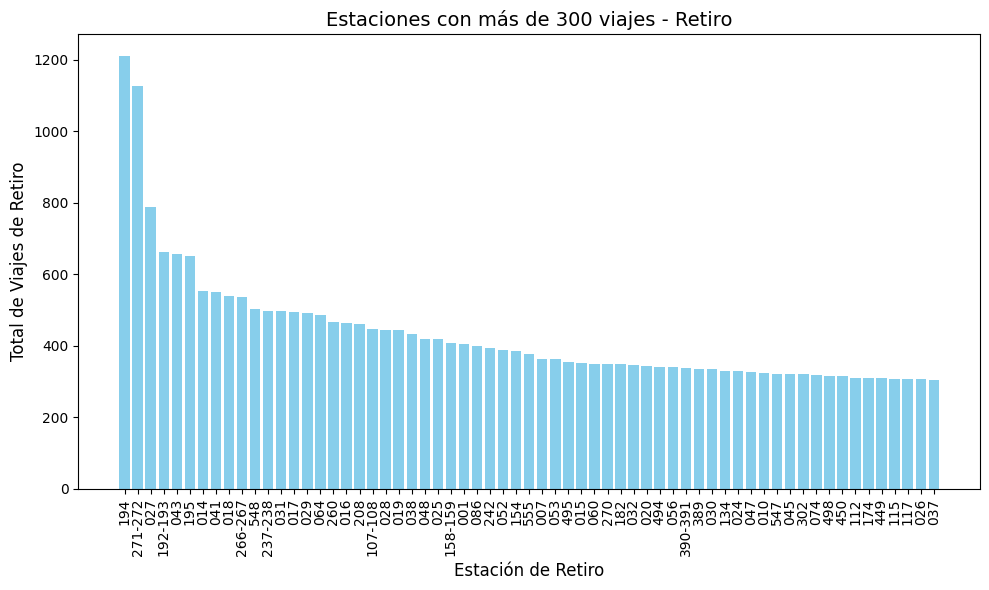

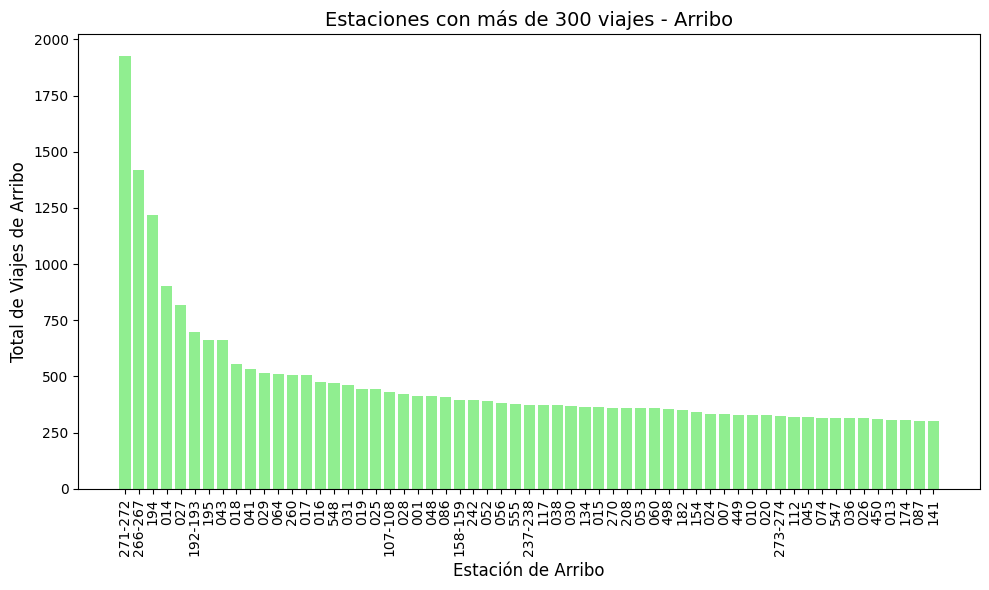

In [81]:
# Filtrar y ordenar las estaciones con más viajes en retiro
viajes_retiro_CE_max_viajes_sorted = viajes_retiro[viajes_retiro['total_viajes_retiro'] > 300].sort_values(by='total_viajes_retiro', ascending=False)

# Filtrar y ordenar las estaciones con más viajes en arribo
viajes_arribo_CE_max_viajes_sorted = viajes_arribo[viajes_arribo['total_viajes_arribo'] > 300].sort_values(by='total_viajes_arribo', ascending=False)

# Graficar las estaciones de retiro con más de 300 viajes
plt.figure(figsize=(10, 6))
plt.bar(viajes_retiro_CE_max_viajes_sorted['Ciclo_Estacion_Retiro'], viajes_retiro_CE_max_viajes_sorted['total_viajes_retiro'], color='skyblue')
plt.title('Estaciones con más de 300 viajes - Retiro', fontsize=14)
plt.xlabel('Estación de Retiro', fontsize=12)
plt.ylabel('Total de Viajes de Retiro', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Mostrar el gráfico de retiro
plt.show()

# Graficar las estaciones de arribo con más de 300 viajes
plt.figure(figsize=(10, 6))
plt.bar(viajes_arribo_CE_max_viajes_sorted['Ciclo_Estacion_Arribo'], viajes_arribo_CE_max_viajes_sorted['total_viajes_arribo'], color='lightgreen')
plt.title('Estaciones con más de 300 viajes - Arribo', fontsize=14)
plt.xlabel('Estación de Arribo', fontsize=12)
plt.ylabel('Total de Viajes de Arribo', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Mostrar el gráfico de arribo
plt.show()

Ciclo estaciones que el mayor numero de viajes, arribo y retiro

In [85]:
viajes_retiro.describe()

,fecha_día_retiro,total_viajes_retiro
count,270468,249987.000000
mean,2024-03-16 11:59:59.999999744,87.177633
min,2023-09-01 00:00:00,1.000000
25%,2023-12-08 18:00:00,42.000000
50%,2024-03-16 12:00:00,70.000000
75%,2024-06-23 06:00:00,112.000000
max,2024-09-30 00:00:00,1211.000000
std,NaN,68.124697


In [84]:
viajes_arribo.describe()

,fecha_día_arribo,total_viajes_arribo
count,270864,250197.000000
mean,2024-03-16 11:59:59.999999744,87.104462
min,2023-09-01 00:00:00,1.000000
25%,2023-12-08 18:00:00,41.000000
50%,2024-03-16 12:00:00,69.000000
75%,2024-06-23 06:00:00,112.000000
max,2024-09-30 00:00:00,1926.000000
std,NaN,78.027574


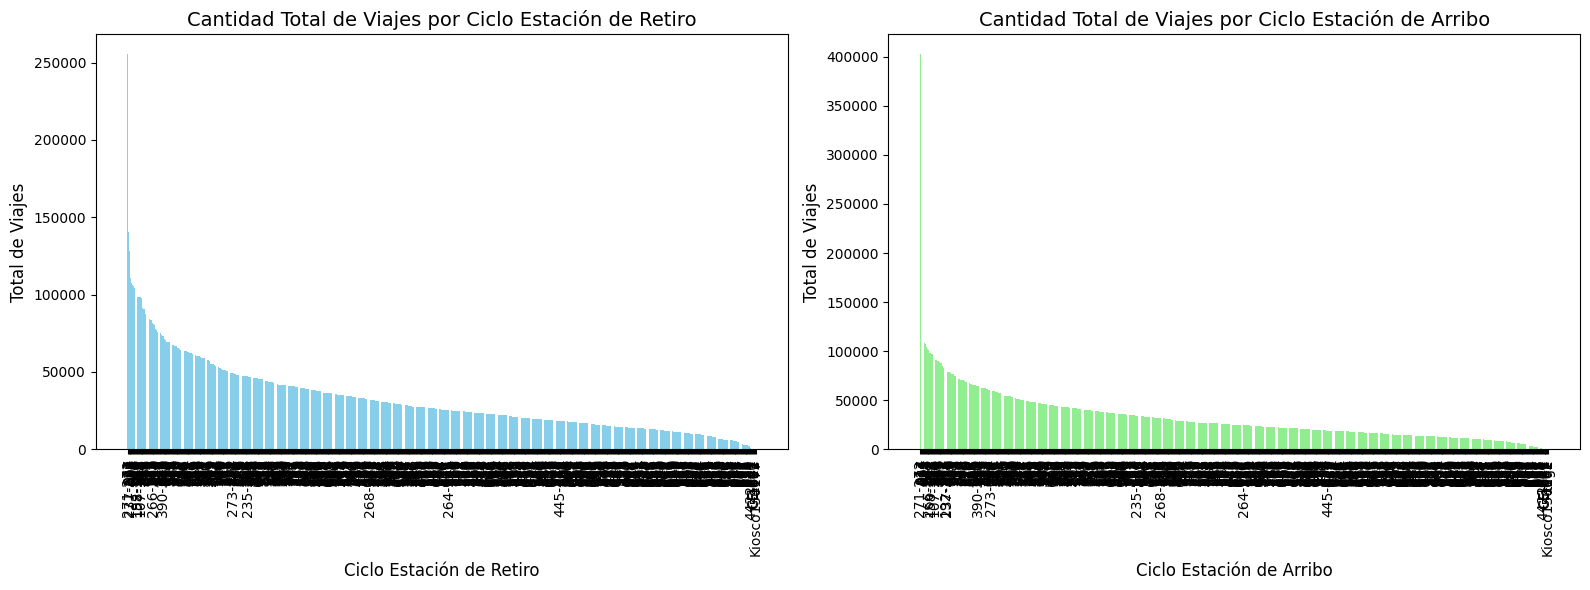

In [82]:
# Agrupar por 'Ciclo_Estacion_Retiro' y 'total_viajes_retiro'
viajes_retiro_por_estacion = viajes_retiro.groupby('Ciclo_Estacion_Retiro')['total_viajes_retiro'].sum().reset_index()

# Agrupar por 'Ciclo_Estacion_Arribo' y 'total_viajes_arribo'
viajes_arribo_por_estacion = viajes_arribo.groupby('Ciclo_Estacion_Arribo')['total_viajes_arribo'].sum().reset_index()

# Ordenar por cantidad total de viajes (opcional)
viajes_retiro_por_estacion.sort_values('total_viajes_retiro', ascending=False, inplace=True)
viajes_arribo_por_estacion.sort_values('total_viajes_arribo', ascending=False, inplace=True)

# Crear una figura con subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de viajes por estación de retiro
axes[0].bar(viajes_retiro_por_estacion['Ciclo_Estacion_Retiro'], viajes_retiro_por_estacion['total_viajes_retiro'], color='skyblue')
axes[0].set_title('Cantidad Total de Viajes por Ciclo Estación de Retiro', fontsize=14)
axes[0].set_xlabel('Ciclo Estación de Retiro', fontsize=12)
axes[0].set_ylabel('Total de Viajes', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Gráfico de viajes por estación de arribo
axes[1].bar(viajes_arribo_por_estacion['Ciclo_Estacion_Arribo'], viajes_arribo_por_estacion['total_viajes_arribo'], color='lightgreen')
axes[1].set_title('Cantidad Total de Viajes por Ciclo Estación de Arribo', fontsize=14)
axes[1].set_xlabel('Ciclo Estación de Arribo', fontsize=12)
axes[1].set_ylabel('Total de Viajes', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

# Ajustar el diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [86]:
# Definir las cicloestaciones sin información reciente en retiro y arribo
estaciones_sin_informacion = {
    "retiro": ['4422222', 'CE-642', 'CE-622', '1002', 'Kiosco 150177', '524', '1000', '511', '711', '710', '530', '529'],
    "arribo": ['4422222', 'CE-642', 'CE-622', '1002', 'Kiosco 150177', 'tag 2', '524', '1000', '511', '711', '710', '530', '529']
}

# Eliminar las cicloestaciones de retiro que no tienen información reciente
viajes_retiro_filtrado = viajes_retiro[~viajes_retiro['Ciclo_Estacion_Retiro'].isin(estaciones_sin_informacion['retiro'])]

# Eliminar las cicloestaciones de arribo que no tienen información reciente
viajes_arribo_filtrado = viajes_arribo[~viajes_arribo['Ciclo_Estacion_Arribo'].isin(estaciones_sin_informacion['arribo'])]

# Verifica que las estaciones fueron eliminadas correctamente
print(viajes_retiro_filtrado.head())
print(viajes_arribo_filtrado.head())

  Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro
0                   001       2023-09-01                254.0
1                   001       2023-09-02                124.0
2                   001       2023-09-03                162.0
3                   001       2023-09-04                245.0
4                   001       2023-09-05                266.0
  Ciclo_Estacion_Arribo fecha_día_arribo  total_viajes_arribo
0                   001       2023-09-01                256.0
1                   001       2023-09-02                133.0
2                   001       2023-09-03                155.0
3                   001       2023-09-04                266.0
4                   001       2023-09-05                306.0


In [87]:
# Análisis de nulos para viajes por retiro
nulos_retiro = viajes_retiro_filtrado['total_viajes_retiro'].isna().sum()
proporcion_nulos_retiro = nulos_retiro / len(viajes_retiro_filtrado)
print("Análisis de nulos para retiro:")
print(f"  - Cantidad de nulos: {nulos_retiro}")
print(f"  - Proporción de nulos: {proporcion_nulos_retiro:.2%}")

# Análisis de nulos para viajes por arribo
nulos_arribo = viajes_arribo_filtrado['total_viajes_arribo'].isna().sum()
proporcion_nulos_arribo = nulos_arribo / len(viajes_arribo_filtrado)
print("\nAnálisis de nulos para arribo:")
print(f"  - Cantidad de nulos: {nulos_arribo}")
print(f"  - Proporción de nulos: {proporcion_nulos_arribo:.2%}")


Análisis de nulos para retiro:
  - Cantidad de nulos: 16640
  - Proporción de nulos: 6.25%

Análisis de nulos para arribo:
  - Cantidad de nulos: 17013
  - Proporción de nulos: 6.38%


<Axes: xlabel='fecha_día_retiro'>

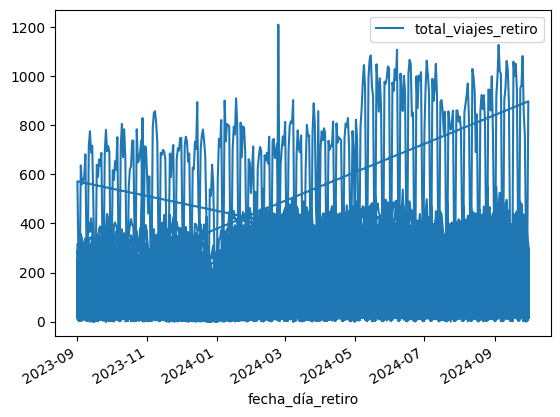

In [88]:
viajes_retiro_filtrado.set_index('fecha_día_retiro').plot()

In [89]:
# Eliminamos registros nulos en arribo
viajes_arribo_filtrado = viajes_arribo_filtrado.dropna(subset=['total_viajes_arribo'])
# Ordenamos por estación y fecha
viajes_arribo_filtrado.sort_values(['Ciclo_Estacion_Arribo', 'fecha_día_arribo'], inplace=True)
# Corroboramos que no haya nulos
print("Información de viajes por arribo (sin nulos):")
print(viajes_arribo_filtrado.info())

# Eliminamos registros nulos en retiro
viajes_retiro_filtrado = viajes_retiro_filtrado.dropna(subset=['total_viajes_retiro'])
# Ordenamos por estación y fecha
viajes_retiro_filtrado.sort_values(['Ciclo_Estacion_Retiro', 'fecha_día_retiro'], inplace=True)
# Corroboramos que no haya nulos
print("\nInformación de viajes por retiro (sin nulos):")
print(viajes_retiro_filtrado.info())


Información de viajes por arribo (sin nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 249495 entries, 0 to 270816
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Ciclo_Estacion_Arribo  249495 non-null  object        
 1   fecha_día_arribo       249495 non-null  datetime64[ns]
 2   total_viajes_arribo    249495 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.6+ MB
None

Información de viajes por retiro (sin nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 249472 entries, 0 to 270191
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Ciclo_Estacion_Retiro  249472 non-null  object        
 1   fecha_día_retiro       249472 non-null  datetime64[ns]
 2   total_viajes_retiro    249472 non-null  float64       
dtypes: datetime64[ns

In [60]:
viajes_retiro.describe()

,fecha_día_retiro,total_viajes_retiro
count,249472,249472.000000
mean,2024-03-24 22:11:51.480247040,87.284665
min,2023-09-01 00:00:00,1.000000
25%,2023-12-23 00:00:00,42.000000
50%,2024-03-28 00:00:00,70.000000
75%,2024-06-29 00:00:00,112.000000
max,2024-09-30 00:00:00,1211.000000
std,NaN,68.139902


### Análisis de Nulos

1. **Conteo de Fechas Nulas**
Después de reindexar, se realizó un conteo de las fechas nulas para cada cicloestación:
- **Cantidad de nulos en retiro:** 20,481
- **Cantidad de nulos en arribo:** 20,667

2. **Evaluación: ¿Son muchas cicloestaciones afectadas?**
- **Cicloestaciones con registros nulos en retiro:** 248
- **Cicloestaciones con registros nulos en arribo:** 249

3. **Evaluación: ¿Son muchos los nulos?**
Se calcula la proporción de nulos en relación al total de registros:
- **Proporción de nulos en retiro:** 7.57%
- **Proporción de nulos en arribo:** 7.63%

4. **Decisión sobre Interpolación**
Al analizar los datos, se identificaron cicloestaciones con características específicas:
- Algunas cicloestaciones tienen muy pocos registros no nulos.
- Existen estaciones que dejaron de utilizarse en los primeros meses del año pasado.
- Otras cicloestaciones comenzaron a usarse recientemente.

Con base en este análisis, se decidió **eliminar las cicloestaciones con un alto número de nulos**, ya que su inclusión podría afectar negativamente la calidad del análisis. Esto permite trabajar con un subconjunto más confiable de datos.

5. **Impacto en el Análisis**
Eliminar cicloestaciones con altos números de nulos asegura que las ventanas temporales sean más representativas y evita la propagación de valores nulos en análisis posteriores. Este enfoque mejora la calidad de los resultados al priorizar datos consistentes.

6. **Cicloestaciones especiales**
Encontramos cicloestaciones con mucha utilidad durante el periodo con un alto numero de retiros y arribos que consideramos pueden tener su propio análisis y modelo por la cantidad de datos que presentan. Caso contrario hay cicloestaciones con muy poco uso el cuál perjudica el modelo y sedecide omitirlos.

Nota: Consultando con el profesor, nos dio ideas de cómo afrontar este problema, las cuales fueron usar date_range, de tal manera usar las fechas a nivel cicloestación para nuestro periodo de principio a fin, otra fue realizar un análisis por archivo y después concadenar. La primera idea se realizó, pero tardaba demaciado en ejecutar y no afecto de manera significativa al modelo, la segunda idea se exploro pero decidimos usar la base de datos completa

## Modelo

In [91]:
viajes_retiro = viajes_retiro_filtrado
viajes_arribo = viajes_arribo_filtrado

In [92]:
# Para los 7 últimos días en retiro
for i in range(1, 8):
    viajes_retiro.loc[:, f't-{i}'] = viajes_retiro.groupby('Ciclo_Estacion_Retiro')['total_viajes_retiro'].shift(i)

# Eliminar nulos en retiro
viajes_retiro.dropna(how='any', inplace=True)

# Para los 7 últimos días en arribo
for i in range(1, 8):
    viajes_arribo.loc[:, f't-{i}'] = viajes_arribo.groupby('Ciclo_Estacion_Arribo')['total_viajes_arribo'].shift(i)

# Eliminar nulos en arribo
viajes_arribo.dropna(how='any', inplace=True)

# Mostrar resultados filtrados
viajes_retiro, viajes_arribo

(       Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro    t-1  \
 7                        001       2023-09-08                243.0  278.0   
 8                        001       2023-09-09                167.0  243.0   
 9                        001       2023-09-10                158.0  167.0   
 10                       001       2023-09-11                272.0  158.0   
 11                       001       2023-09-12                255.0  272.0   
 ...                      ...              ...                  ...    ...   
 268483                   709       2024-09-26                 30.0   45.0   
 268484                   709       2024-09-27                 38.0   30.0   
 268485                   709       2024-09-28                 26.0   38.0   
 268486                   709       2024-09-29                 45.0   26.0   
 268487                   709       2024-09-30                 49.0   45.0   
 
           t-2    t-3    t-4    t-5    t-6    t-7  
 7       2

In [94]:
# Método de la regla de Tukey (IQR) para "retiro"
q12_retiro = viajes_retiro['total_viajes_retiro'].quantile(0.25)
q32_retiro = viajes_retiro['total_viajes_retiro'].quantile(0.75)
IQR_retiro = q32_retiro - q12_retiro

# Límites para retiro
li_retiro = q12_retiro - 1.5 * IQR_retiro
ls_retiro = q32_retiro + 1.5 * IQR_retiro

# Outliers en retiro
outliers_retiro = viajes_retiro[(viajes_retiro['total_viajes_retiro'] < li_retiro) | (viajes_retiro['total_viajes_retiro'] > ls_retiro)]

# Porción de los outliers en retiro
print(f"Porción de outliers en retiro: {len(outliers_retiro) / len(viajes_retiro):.2%}")

# Si también necesitas hacerlo para "arribo":
q12_arribo = viajes_arribo['total_viajes_arribo'].quantile(0.25)
q32_arribo = viajes_arribo['total_viajes_arribo'].quantile(0.75)
IQR_arribo = q32_arribo - q12_arribo

# Límites para arribo
li_arribo = q12_arribo - 1.5 * IQR_arribo
ls_arribo = q32_arribo + 1.5 * IQR_arribo

# Outliers en arribo
outliers_arribo = viajes_arribo[(viajes_arribo['total_viajes_arribo'] < li_arribo) | (viajes_arribo['total_viajes_arribo'] > ls_arribo)]

# Porción de los outliers en arribo
print(f"Porción de outliers en arribo: {len(outliers_arribo) / len(viajes_arribo):.2%}")


Porción de outliers en retiro: 4.70%
Porción de outliers en arribo: 4.87%


In [96]:
# Filtrar los datos de arribo para eliminar los outliers
viajes_retiro = viajes_retiro[(viajes_retiro['total_viajes_retiro'] >= li_retiro) & (viajes_retiro['total_viajes_retiro'] <= ls_retiro)] 
# Filtrar los datos de arribo para eliminar los outliers
viajes_arribo = viajes_arribo[(viajes_arribo['total_viajes_arribo'] >= li_arribo) & (viajes_arribo['total_viajes_arribo'] <= ls_arribo)]

# Mostrar el DataFrame filtrado
viajes_retiro, viajes_arribo

(       Ciclo_Estacion_Retiro fecha_día_retiro  total_viajes_retiro    t-1  \
 8                        001       2023-09-09                167.0  243.0   
 9                        001       2023-09-10                158.0  167.0   
 14                       001       2023-09-15                150.0  252.0   
 15                       001       2023-09-16                 90.0  150.0   
 16                       001       2023-09-17                137.0   90.0   
 ...                      ...              ...                  ...    ...   
 268483                   709       2024-09-26                 30.0   45.0   
 268484                   709       2024-09-27                 38.0   30.0   
 268485                   709       2024-09-28                 26.0   38.0   
 268486                   709       2024-09-29                 45.0   26.0   
 268487                   709       2024-09-30                 49.0   45.0   
 
           t-2    t-3    t-4    t-5    t-6    t-7  
 8       2

In [99]:
#Definir variables para el modelo

x_retiro = viajes_retiro[['t-1', 't-2','t-3', 't-4', 't-5', 't-6', 't-7']]
y_retiro = viajes_retiro['total_viajes_retiro']

#Modelo
modelo_retiro = LinearRegression()

print(modelo_retiro.fit(x_retiro, y_retiro))
print(modelo_retiro.score(x_retiro, y_retiro))
print('\n')

#Prredicción
viajes_retiro['Predicción_Retiro'] = modelo_retiro.predict(x_retiro)
viajes_retiro.reset_index()


LinearRegression()
0.8233919548256169




C:\Users\ANMEJIA\AppData\Local\Temp\ipykernel_110312\1846515255.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viajes_retiro['Predicción_Retiro'] = modelo_retiro.predict(x_retiro)


,index,Ciclo_Estacion_Retiro,fecha_día_retiro,total_viajes_retiro,t-1,t-2,t-3,t-4,t-5,t-6,t-7,Predicción_Retiro
0,8,001,2023-09-09,167.0,243.0,278.0,216.0,266.0,245.0,162.0,124.0,148.995537
1,9,001,2023-09-10,158.0,167.0,243.0,278.0,216.0,266.0,245.0,162.0,160.767601
2,14,001,2023-09-15,150.0,252.0,269.0,255.0,272.0,158.0,167.0,243.0,218.541129
3,15,001,2023-09-16,90.0,150.0,252.0,269.0,255.0,272.0,158.0,167.0,143.042826
4,16,001,2023-09-17,137.0,90.0,150.0,252.0,269.0,255.0,272.0,158.0,145.929987
...,...,...,...,...,...,...,...,...,...,...,...,...
233269,268483,709,2024-09-26,30.0,45.0,50.0,65.0,74.0,37.0,68.0,51.0,54.753280
233270,268484,709,2024-09-27,38.0,30.0,45.0,50.0,65.0,74.0,37.0,68.0,52.463716
233271,268485,709,2024-09-28,26.0,38.0,30.0,45.0,50.0,65.0,74.0,37.0,46.125870
233272,268486,709,2024-09-29,45.0,26.0,38.0,30.0,45.0,50.0,65.0,74.0,60.219720


In [100]:
# Definir variables para el modelo en arribo
x_arribo = viajes_arribo[['t-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7']]
y_arribo = viajes_arribo['total_viajes_arribo']

# Crear el modelo
modelo_arribo = LinearRegression()

# Ajustar el modelo
print(modelo_arribo.fit(x_arribo, y_arribo))
print(modelo_arribo.score(x_arribo, y_arribo))
print('\n')

# Realizar predicción
viajes_arribo['Predicción_Arribo'] = modelo_arribo.predict(x_arribo)
viajes_arribo.reset_index()


LinearRegression()
0.8317902364525762




C:\Users\ANMEJIA\AppData\Local\Temp\ipykernel_110312\422358307.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viajes_arribo['Predicción_Arribo'] = modelo_arribo.predict(x_arribo)


,index,Ciclo_Estacion_Arribo,fecha_día_arribo,total_viajes_arribo,t-1,t-2,t-3,t-4,t-5,t-6,t-7,Predicción_Arribo
0,0,001,2023-09-09,169.0,276.0,267.0,263.0,306.0,266.0,155.0,133.0,163.028423
1,1,001,2023-09-10,183.0,169.0,276.0,267.0,263.0,306.0,266.0,155.0,158.072013
2,2,001,2023-09-15,195.0,298.0,304.0,273.0,302.0,183.0,169.0,276.0,247.629820
3,3,001,2023-09-16,90.0,195.0,298.0,304.0,273.0,302.0,183.0,169.0,159.079338
4,4,001,2023-09-17,132.0,90.0,195.0,298.0,304.0,273.0,302.0,183.0,159.900623
...,...,...,...,...,...,...,...,...,...,...,...,...
232858,232858,709,2024-09-26,39.0,44.0,52.0,63.0,79.0,46.0,81.0,61.0,60.857633
232859,232859,709,2024-09-27,43.0,39.0,44.0,52.0,63.0,79.0,46.0,81.0,63.381839
232860,232860,709,2024-09-28,46.0,43.0,39.0,44.0,52.0,63.0,79.0,46.0,52.376520
232861,232861,709,2024-09-29,41.0,46.0,43.0,39.0,44.0,52.0,63.0,79.0,68.102205


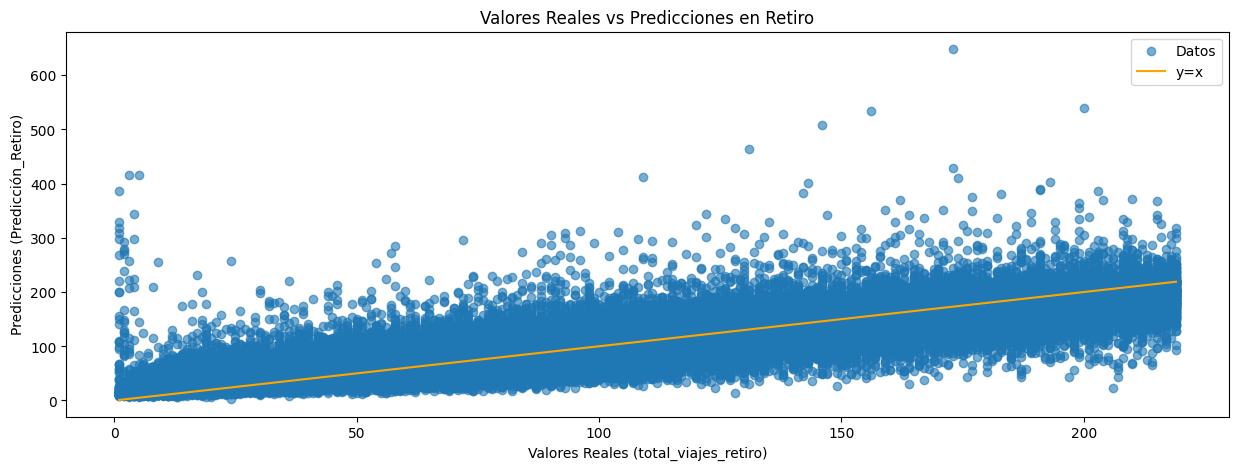

C:\Users\ANMEJIA\AppData\Local\Temp\ipykernel_110312\3172215687.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viajes_arribo['Predicción_Arribo'] = modelo_arribo.predict(x_arribo)


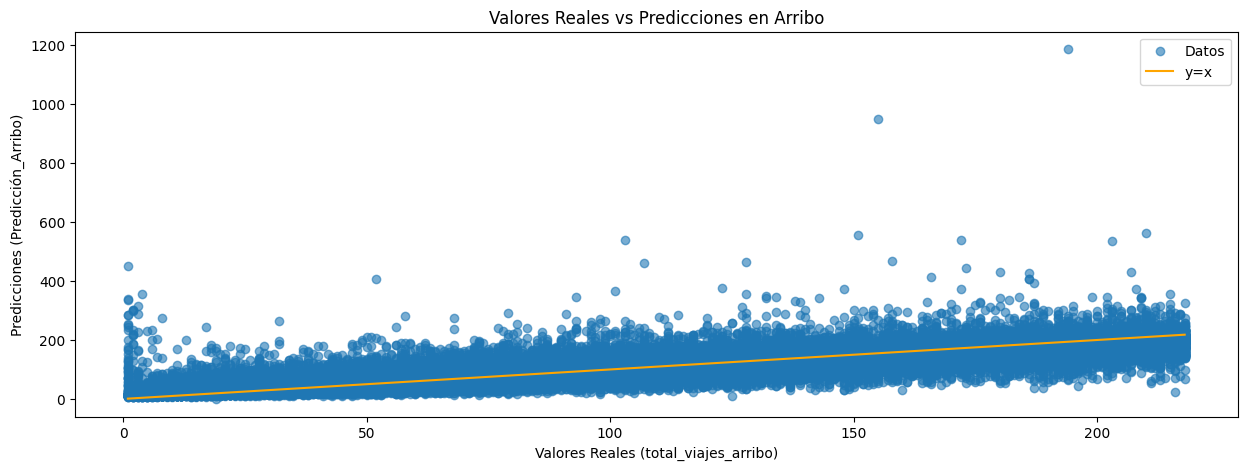

In [109]:
# Gráfica para Retiro
plt.figure(figsize=(15, 5))

# Gráfico de dispersión
plt.scatter(y_retiro, viajes_retiro['Predicción_Retiro'], label='Datos', alpha=0.6)

# Recta y=x
plt.plot([min(y_retiro), max(y_retiro)], [min(y_retiro), max(y_retiro)], color='orange', linestyle='-', label='y=x')

# Etiquetas
plt.title('Valores Reales vs Predicciones en Retiro')
plt.xlabel('Valores Reales (total_viajes_retiro)')
plt.ylabel('Predicciones (Predicción_Retiro)')
plt.legend()

# Márgenes
x_margin_retiro = 0.05 * (max(y_retiro) - min(y_retiro))
y_margin_retiro = 0.05 * (max(viajes_retiro['Predicción_Retiro']) - min(viajes_retiro['Predicción_Retiro']))

# Ajuste de los límites de los ejes con márgenes
plt.xlim([min(y_retiro) - x_margin_retiro, max(y_retiro) + x_margin_retiro])
plt.ylim([min(viajes_retiro['Predicción_Retiro']) - y_margin_retiro, max(viajes_retiro['Predicción_Retiro']) + y_margin_retiro])

# Mostrar gráfica
plt.show()

# Realizar predicción para Arribo
viajes_arribo['Predicción_Arribo'] = modelo_arribo.predict(x_arribo)

# Gráfica para Arribo
plt.figure(figsize=(15, 5))

# Gráfico de dispersión
plt.scatter(y_arribo, viajes_arribo['Predicción_Arribo'], label='Datos', alpha=0.6)

# Recta y=x
plt.plot([min(y_arribo), max(y_arribo)], [min(y_arribo), max(y_arribo)], color='orange', linestyle='-', label='y=x')

# Etiquetas
plt.title('Valores Reales vs Predicciones en Arribo')
plt.xlabel('Valores Reales (total_viajes_arribo)')
plt.ylabel('Predicciones (Predicción_Arribo)')
plt.legend()

# Márgenes
x_margin_arribo = 0.05 * (max(y_arribo) - min(y_arribo))
y_margin_arribo = 0.05 * (max(viajes_arribo['Predicción_Arribo']) - min(viajes_arribo['Predicción_Arribo']))

# Ajuste de los límites de los ejes con márgenes
plt.xlim([min(y_arribo) - x_margin_arribo, max(y_arribo) + x_margin_arribo])
plt.ylim([min(viajes_arribo['Predicción_Arribo']) - y_margin_arribo, max(viajes_arribo['Predicción_Arribo']) + y_margin_arribo])

# Mostrar gráfica
plt.show()

### Interpretación:

Ambos modelos tienen un buen desempeño, ya que los valores de \( R^2 \) son cercanos a 1, lo que sugiere que los modelos explican una gran parte de la variabilidad en las series temporales de viajes de arribo y retiro.

Aunque ambos modelos son efectivos, el de arribo tiene un ligeramente mejor desempeño (83.18% frente al 82.34%), lo que indica que las variables utilizadas en el modelo de arribo podrían tener una relación ligeramente más fuerte con los viajes de arribo que con los viajes de retiro.


## Retiro Vs Arribo

In [110]:
#Df's con las predicciones
display(viajes_retiro, viajes_arribo)

,Ciclo_Estacion_Retiro,fecha_día_retiro,total_viajes_retiro,t-1,t-2,t-3,t-4,t-5,t-6,t-7,Predicción_Retiro
8,001,2023-09-09,167.0,243.0,278.0,216.0,266.0,245.0,162.0,124.0,148.995537
9,001,2023-09-10,158.0,167.0,243.0,278.0,216.0,266.0,245.0,162.0,160.767601
14,001,2023-09-15,150.0,252.0,269.0,255.0,272.0,158.0,167.0,243.0,218.541129
15,001,2023-09-16,90.0,150.0,252.0,269.0,255.0,272.0,158.0,167.0,143.042826
16,001,2023-09-17,137.0,90.0,150.0,252.0,269.0,255.0,272.0,158.0,145.929987
...,...,...,...,...,...,...,...,...,...,...,...
268483,709,2024-09-26,30.0,45.0,50.0,65.0,74.0,37.0,68.0,51.0,54.753280
268484,709,2024-09-27,38.0,30.0,45.0,50.0,65.0,74.0,37.0,68.0,52.463716
268485,709,2024-09-28,26.0,38.0,30.0,45.0,50.0,65.0,74.0,37.0,46.125870
268486,709,2024-09-29,45.0,26.0,38.0,30.0,45.0,50.0,65.0,74.0,60.219720


,Ciclo_Estacion_Arribo,fecha_día_arribo,total_viajes_arribo,t-1,t-2,t-3,t-4,t-5,t-6,t-7,Predicción_Arribo
0,001,2023-09-09,169.0,276.0,267.0,263.0,306.0,266.0,155.0,133.0,163.028423
1,001,2023-09-10,183.0,169.0,276.0,267.0,263.0,306.0,266.0,155.0,158.072013
2,001,2023-09-15,195.0,298.0,304.0,273.0,302.0,183.0,169.0,276.0,247.629820
3,001,2023-09-16,90.0,195.0,298.0,304.0,273.0,302.0,183.0,169.0,159.079338
4,001,2023-09-17,132.0,90.0,195.0,298.0,304.0,273.0,302.0,183.0,159.900623
...,...,...,...,...,...,...,...,...,...,...,...
232858,709,2024-09-26,39.0,44.0,52.0,63.0,79.0,46.0,81.0,61.0,60.857633
232859,709,2024-09-27,43.0,39.0,44.0,52.0,63.0,79.0,46.0,81.0,63.381839
232860,709,2024-09-28,46.0,43.0,39.0,44.0,52.0,63.0,79.0,46.0,52.376520
232861,709,2024-09-29,41.0,46.0,43.0,39.0,44.0,52.0,63.0,79.0,68.102205


In [111]:
#Haremos un merge para unir los df's y comparar la variación entre las predicciones
df_comparacion = viajes_arribo.merge(viajes_retiro[['Ciclo_Estacion_Retiro', 'fecha_día_retiro', 'Predicción_Retiro']], left_on=['Ciclo_Estacion_Arribo', 'fecha_día_arribo'], right_on=['Ciclo_Estacion_Retiro', 'fecha_día_retiro'], how='inner')

In [ ]:
#Filtramos colo las columnas d einterés y las renombramos
df_comparacion=df_comparacion[['Ciclo_Estacion_Arribo', 'fecha_día_arribo', 'Predicción_Arribo', 'Predicción_Retiro']]
df_comparacion.rename(columns = {'Ciclo_Estacion_Arribo': 'Ciclo_Estación',  'fecha_día_arribo': 'fecha_día'}, inplace=True)
df_comparacion

,Ciclo_Estación,fecha_día,Predicción_Arribo,Predicción_Retiro
0,001,2023-09-09,163.028423,148.995537
1,001,2023-09-10,158.072013,160.767601
2,001,2023-09-15,247.629820,218.541129
3,001,2023-09-16,159.079338,143.042826
4,001,2023-09-17,159.900623,145.929987
...,...,...,...,...
231238,709,2024-09-26,60.857633,54.753280
231239,709,2024-09-27,63.381839,52.463716
231240,709,2024-09-28,52.376520,46.125870
231241,709,2024-09-29,68.102205,60.219720


In [113]:
#Estación con mayor diferencia entre ambas predicciones
df_comparacion['Diferencia'] = df_comparacion['Predicción_Arribo'] - df_comparacion['Predicción_Retiro']
df_comparacion

,Ciclo_Estación,fecha_día,Predicción_Arribo,Predicción_Retiro,Diferencia
0,001,2023-09-09,163.028423,148.995537,14.032886
1,001,2023-09-10,158.072013,160.767601,-2.695587
2,001,2023-09-15,247.629820,218.541129,29.088691
3,001,2023-09-16,159.079338,143.042826,16.036513
4,001,2023-09-17,159.900623,145.929987,13.970636
...,...,...,...,...,...
231238,709,2024-09-26,60.857633,54.753280,6.104353
231239,709,2024-09-27,63.381839,52.463716,10.918123
231240,709,2024-09-28,52.376520,46.125870,6.250649
231241,709,2024-09-29,68.102205,60.219720,7.882485


In [ ]:
#Estación con mayor diferencia
df_comparacion[df_comparacion['Diferencia'] == abs(df_comparacion['Diferencia'].max())]

,Ciclo_Estación,fecha_día,Predicción_Arribo,Predicción_Retiro,Diferencia
89830,271-272,2024-09-16,1186.956918,648.060669,538.89625


In [117]:
#Algunos registros de esa estación en df_arribo y df_retiro
display(df_comparacion[df_comparacion['Ciclo_Estación'] == '271-272'])

,Ciclo_Estación,fecha_día,Predicción_Arribo,Predicción_Retiro,Diferencia
89823,271-272,2023-09-10,287.491379,241.454028,46.037351
89824,271-272,2023-09-16,236.197543,279.214398,-43.016855
89825,271-272,2023-09-17,298.223311,240.913353,57.309958
89826,271-272,2023-10-15,310.831197,264.776963,46.054234
89827,271-272,2023-12-25,950.312273,508.343679,441.968594
89828,271-272,2024-01-01,260.080504,215.961058,44.119446
89829,271-272,2024-06-23,427.158870,354.911735,72.247135
89830,271-272,2024-09-16,1186.956918,648.060669,538.896250


## Conclusiones

### Análisis de la Estación con Mayor Variación entre Pronósticos de Arribo y Retiro

**Estación con Mayor Diferencia:**

**Ciclo_Estación:** 271-272  
**Fecha:** 2024-09-16  
**Predicción de Arribo:** 1186.96  
**Predicción de Retiro:** 648.06  
**Diferencia:** 538.90

**Estación con Mayor Diferencia entre Ambas Predicciones:**
Se observa que la estación 271-272 tiene la mayor diferencia en los pronósticos de arribo y retiro, con una diferencia de 538.90 el 2024-09-16. Sin embargo, la estación 271-272 muestra variaciones significativas a lo largo del tiempo, como se refleja en las diferencias entre los pronósticos de arribo y retiro:

| **Ciclo_Estación** | **Fecha_día** | **Predicción_Arribo** | **Predicción_Retiro** | **Diferencia** |
|--------------------|---------------|-----------------------|-----------------------|----------------|
| 271-272            | 2023-09-10    | 287.49                | 241.45                | 46.04          |
| 271-272            | 2023-09-16    | 236.20                | 279.21                | -43.02         |
| 271-272            | 2023-09-17    | 298.22                | 240.91                | 57.31          |
| 271-272            | 2023-10-15    | 310.83                | 264.78                | 46.05          |
| 271-272            | 2023-12-25    | 950.31                | 508.34                | 441.97         |
| 271-272            | 2024-01-01    | 260.08                | 215.96                | 44.12          |
| 271-272            | 2024-06-23    | 427.16                | 354.91                | 72.25          |
| 271-272            | 2024-09-16    | 1186.96               | 648.06                | 538.90         |

**Análisis de la Diferencia:**
En este caso, la estación 271-272 muestra una gran variabilidad entre los pronósticos de arribo y retiro en varias fechas, con una diferencia especialmente alta el 2024-09-16 (538.90). Esto podría reflejar una serie de factores que están afectando la predicción de los viajes de retiro en comparación con los de arribo, como la estacionalidad o cambios inesperados en los patrones de los viajes.

**Influencia en el Entorno:**
En la CDMX, una gran diferencia entre las predicciones de arribo y retiro en las cicloestaciones puede indicar problemas de programación o distribución de bicicletas. Si muchas bicicletas llegan a una estación y no se retiran, puede haber desabastecimiento y tiempos de espera largos. Por otro lado, si hay demasiadas bicicletas sin retirar, la estación podría sobrecargarse, afectando la disponibilidad para otros usuarios. Estos desajustes podrían generar problemas en la infraestructura de las cicloestaciones y en la experiencia del usuario.

**Conclusiones:**
- Las grandes diferencias en las predicciones de arribo y retiro, como las observadas el 2024-09-16, requieren un análisis más detallado para identificar factores subyacentes.
- Es crucial ajustar las predicciones de forma continua para mejorar la eficiencia operativa y evitar desajustes significativos entre arribo y retiro.
- Mejorar los modelos de predicción puede llevar a una mejor asignación de recursos y optimización de las operaciones.